In [5]:
import numpy as np
import json
import cv2
import pandas as pd
from scipy import ndimage
import matplotlib.pylab as plt

In [12]:
def get_data(index, cf):
    begin_cf = cf.columns.get_loc("0")
    data_array = cf.iloc[index, begin_cf:begin_cf+167].values
    N = len(data_array)

    nr_joints = len(eval(data_array[0]))
    
    data = np.zeros((N,nr_joints,2))

    for j in range(N):
        if not pd.isnull(data_array[j]):
            data[j]=np.array(eval(data_array[j]))
        else:
            data[j] = data[j-1]
    return data

def only_first(move, minimum_sequ_len = 1):
    while True:
        for i in range(minimum_sequ_len):
            if move[0]!=move[1]-1:
                move = np.delete(move, 0)
            else:
                return move[0]
def first_by_grad(frames_joints_array, relevant_joints_list, cutoff):
    """ 
    frames_joint_array must have size (nr_frames, 18/12 (joints))
    relevant_joints_list: the joints which should be taken into account for the movement
    """
    #frames_joints_array = ndimage.filters.gaussian_filter1d(frames_joints_array, axis =0, sigma = 3)
    gradients = np.array([np.gradient(frames_joints_array[:,joints_list.index(j)], edge_order = 2) 
                          for j in relevant_joints_list]) #["right_knee", "right_ankle", "left_knee", "left_ankle"]])
    # print(gradients.shape)
    mean_gradient = np.median(gradients, axis=0)
    #print(mean_gradient)
    if cutoff>0:
        move = np.where(mean_gradient>cutoff)[0] 
    else: 
        move = np.where(mean_gradient<cutoff)[0] 
    print("first_by_grad", move)
    if len(move)>1:
        return only_first(move)
    elif len(move)==1:
        return move[0]
    else:
        return None

In [6]:
videos_b = np.array([np.load("/Users/ninawiedemann/Desktop/UNI/Praktikum/ALL/video_to_pitchtype_directly/outs/batter_example.npy")])
game_id = "490509-3f640b3f-9ba5-4e89-8f72-97c9f333aa2c"
center_csv = pd.read_csv("/Users/ninawiedemann/Desktop/UNI/Praktikum/ALL/cf_data.csv")
center_csv = center_csv[center_csv["Player"]=="Batter"]
games_batter = center_csv["Game"].values.tolist()
ind = games_batter.index(game_id)
joints_array_batter = np.array([get_data(ind, center_csv)])
joints_array_batter = ndimage.filters.gaussian_filter1d(joints_array_batter, axis =1, sigma = 3)
print(joints_array_batter.shape, videos_b.shape)

/Users/ninawiedemann/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (253,254,255,256,257,258,259,289) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


NameError: name 'get_data' is not defined

In [24]:
path="/Users/ninawiedemann/Desktop/UNI/Praktikum/ALL/video_to_pitchtype_directly/outs/batter/"
from os import listdir
import codecs
import json
videos_b = []
joints_array_batter = []
files = []
csv = pd.read_csv("/Users/ninawiedemann/Desktop/UNI/Praktikum/csvs/csv_new_videos.csv")
#csv = csv[csv["Player"]=="Batter"]
hit_into = []
for fi in listdir(path):
    if fi[-5:]==".json":
        files.append(fi[:-5])
        line = csv[csv["play_id"]==fi[:-5]]
        hit_into.append(line["Hit into play?"].values[0])
        videos_b.append(np.load(path+fi[:-5]+"_video.npy"))
        obj_text = codecs.open(path+fi, encoding='utf-8').read()
        joints_array_batter.append(json.loads(obj_text))

# 88009707-e682-405a-8644-92d5b20a155e_video.npy
# "88009707-e682-405a-8644-92d5b20a155e.json"

joints_array_batter = np.array(joints_array_batter)
videos_b = np.array(videos_b)
joints_array_batter = ndimage.filters.gaussian_filter1d(joints_array_batter, axis =1, sigma = 3)
print(videos_b.shape, joints_array_batter.shape)
print(hit_into)

(52, 167, 110, 110) (52, 167, 18, 2)
['no', 'yes', 'yes', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'no', 'no', 'no', 'no', 'no', 'yes', 'no', 'yes', 'no', 'no', 'yes', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'yes', 'no', 'yes', 'no', 'no', 'yes', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'yes']


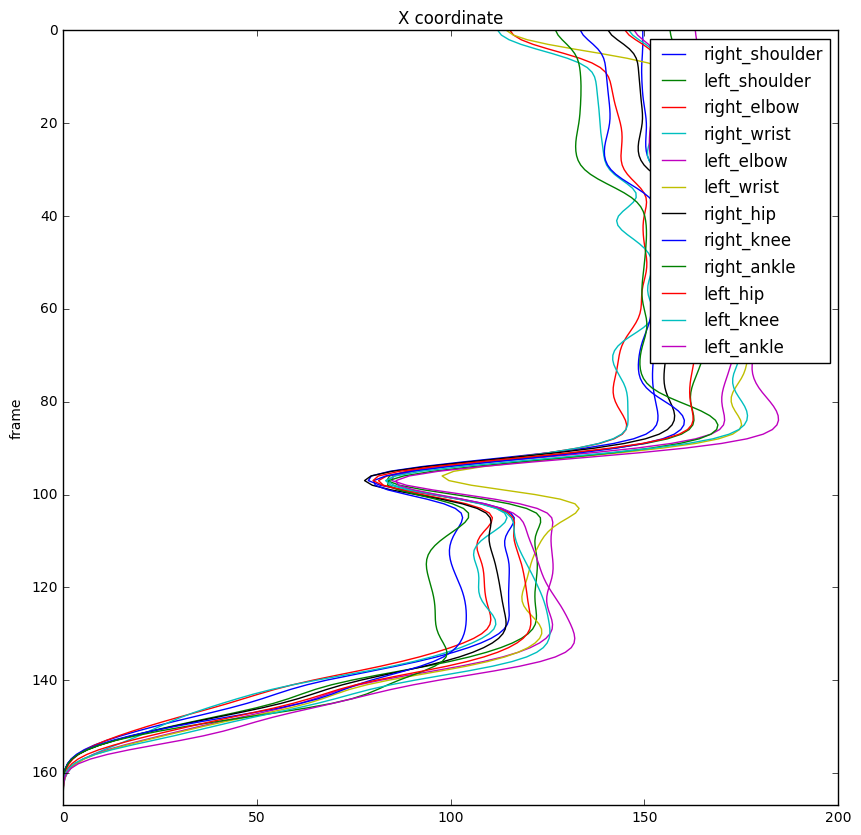

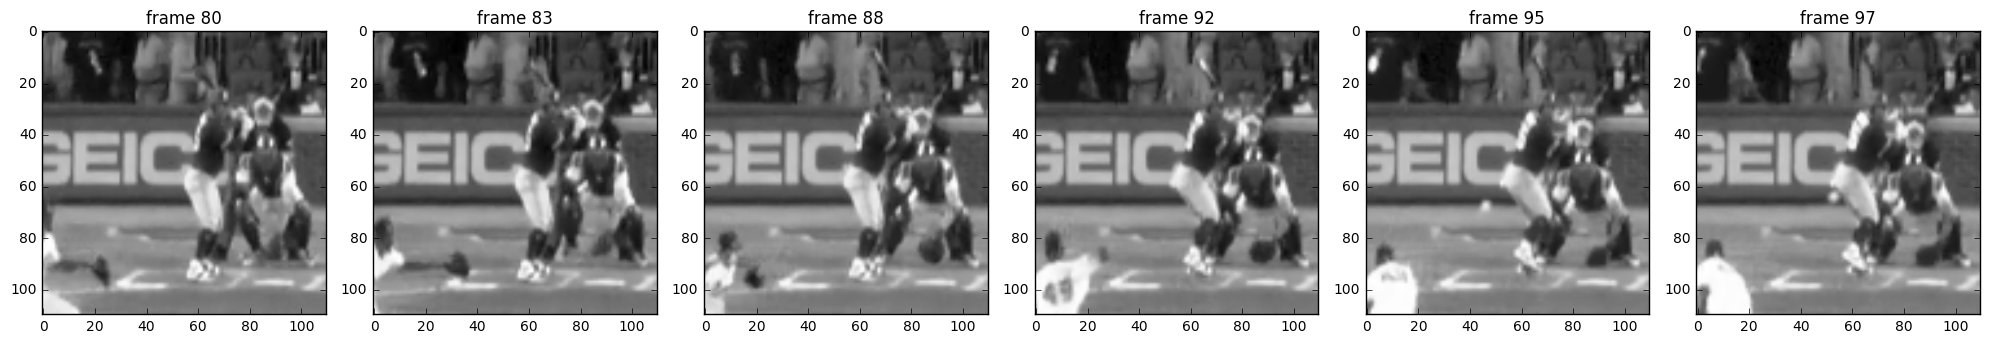

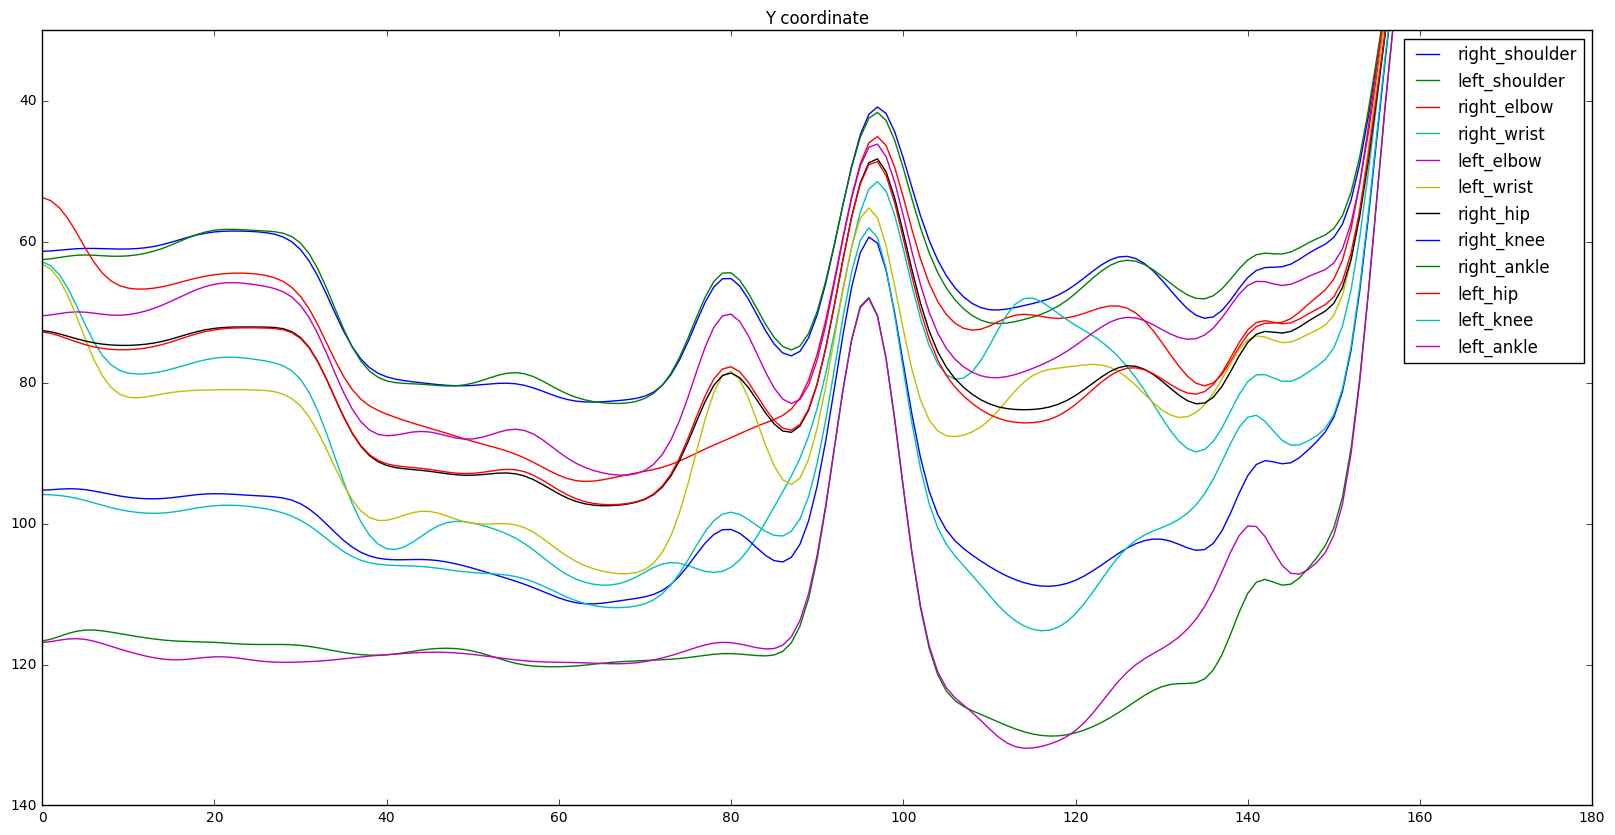

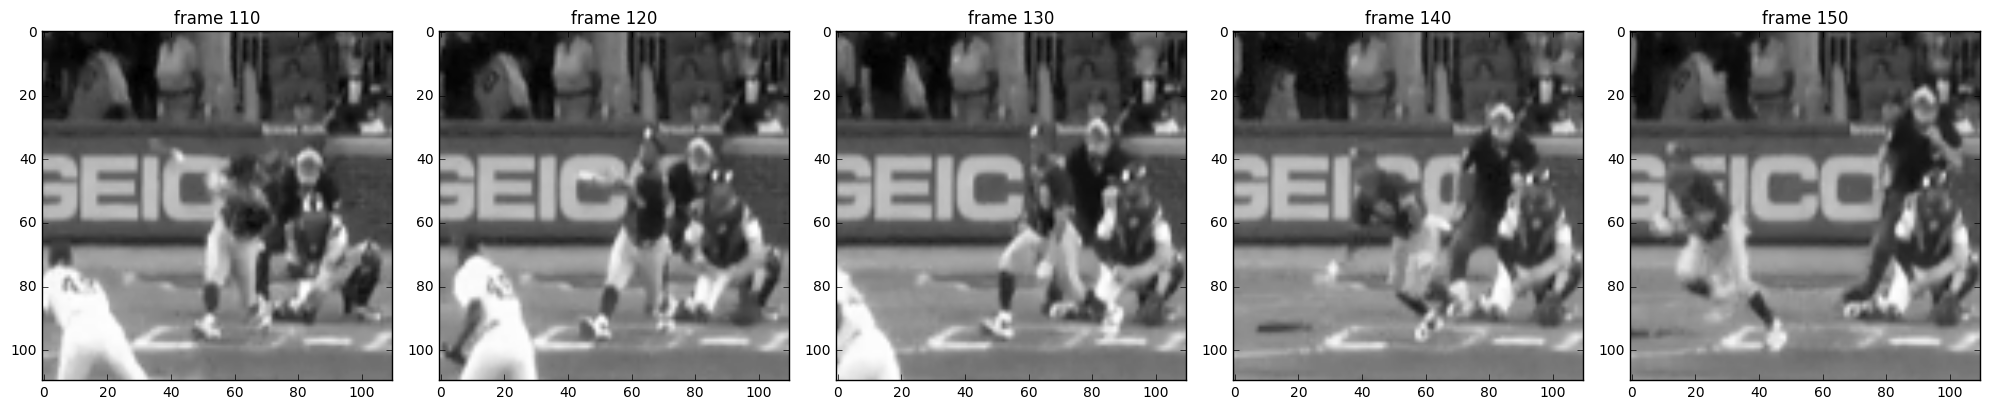

In [39]:
import matplotlib.pylab as plt

joints_list = ["right_shoulder", "left_shoulder", "right_elbow", "right_wrist","left_elbow", "left_wrist",
        "right_hip", "right_knee", "right_ankle", "left_hip", "left_knee", "left_ankle", "neck ",
        "right_eye", "right_ear","left_eye", "left_ear"]
# print(files)
one_joint = "left_knee"
video_choice = files.index("aa7193ad-30f0-4f3e-becb-4f68d0b65130")
#SMOOTHING

plt.figure(figsize = (10,10))
for j in joints_list[:12]:
    plt.plot(joints_array_batter[video_choice,:,joints_list.index(j), 1], np.arange(0,167,1), label = j)
plt.title("X coordinate")
plt.ylim(167,0)
plt.ylabel("frame")
plt.legend()
plt.show()

# Plot video frames to visualize maxima in X coordinates
show_frames = [80, 83, 88, 92, 95, 97]
fig = plt.figure(figsize=(20, 5))
for ind, i in enumerate(show_frames):
    ax = fig.add_subplot(1,len(show_frames),ind+1)
    plt.imshow(videos_b[video_choice,i])
    plt.title("frame "+str(i))
    plt.gray()
plt.tight_layout()
plt.show()


plt.figure(figsize = (20,10))
for j in joints_list[:12]: #[one_joint]: 
    plt.plot(joints_array_batter[video_choice,:,joints_list.index(j), 0], label = j)
plt.legend()
plt.ylim(140, 30)
plt.title("Y coordinate")
plt.show()

# Plot video frames to visualize maxima in Y coordinates
show_frames = [110, 120, 130, 140, 150]
fig = plt.figure(figsize=(20, 5))
for ind, i in enumerate(show_frames):
    ax = fig.add_subplot(1,len(show_frames),ind+1)
    plt.imshow(videos_b[video_choice,i])
    plt.title("frame "+str(i))
plt.tight_layout()
plt.show()


 
 
 

--------------NEW VIDEO ------------------
0a208ce7-c3e8-49a6-b17b-d762aec31f09
-----------------Hit into play?  yes -----------
first_by_grad [126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144]
--------------START RUN:  126 ------------------


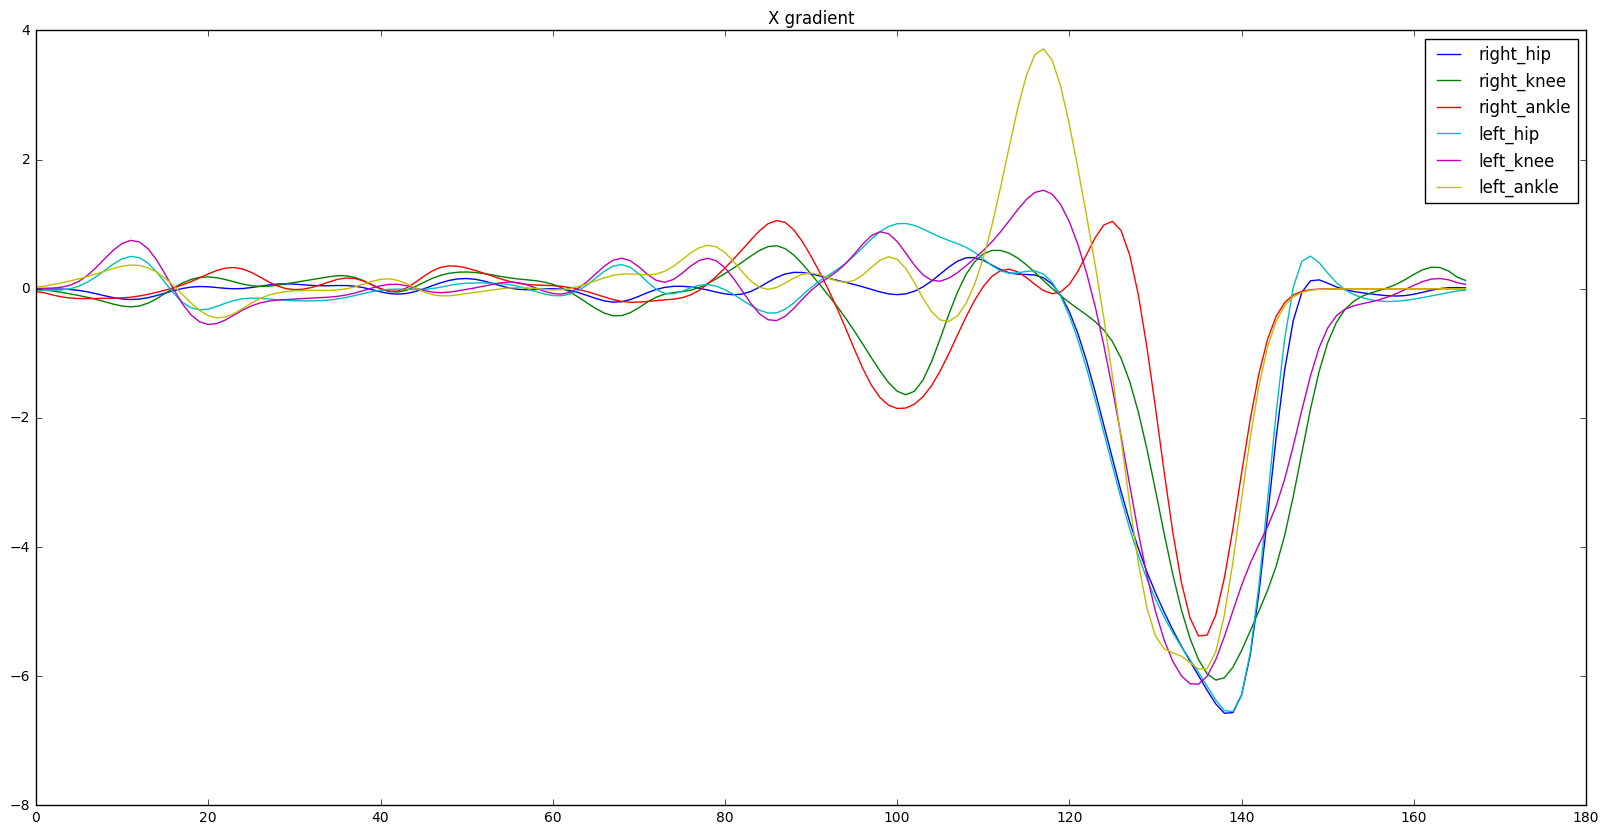

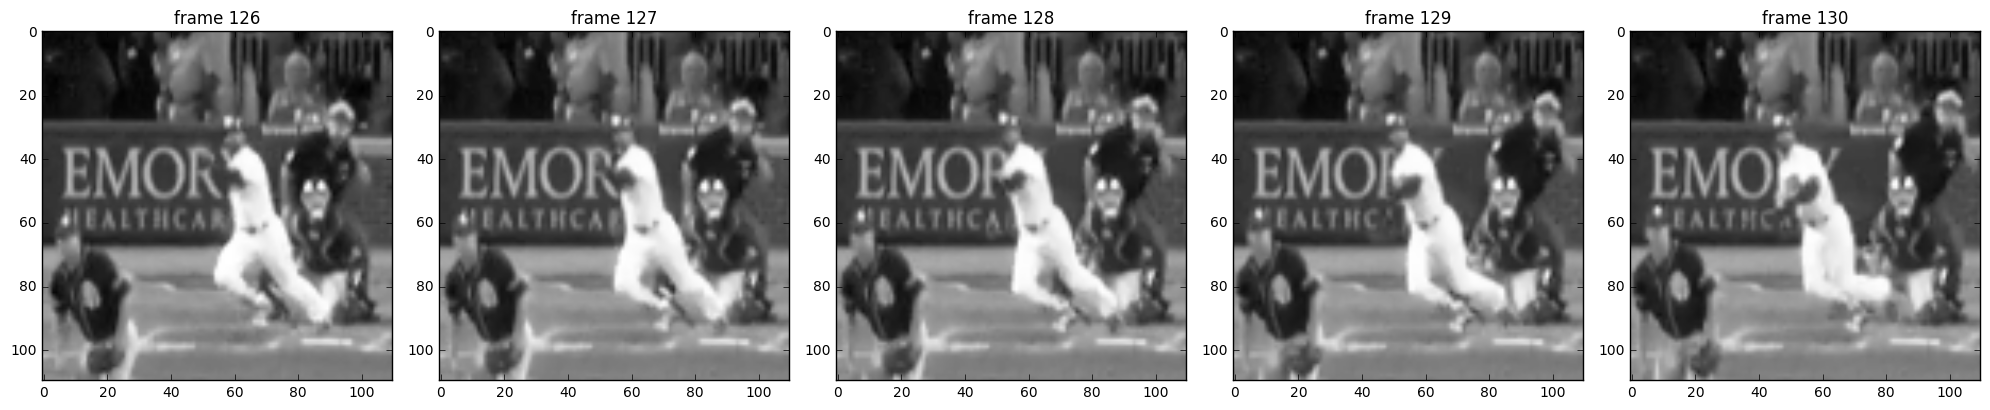


 
 
 

--------------NEW VIDEO ------------------
1693239c-25e5-42ac-8626-1513ac268fc8
-----------------Hit into play?  yes -----------
first_by_grad [122 123 124 125 126 127 128 129 130 131 132 133 134 135]
--------------START RUN:  122 ------------------


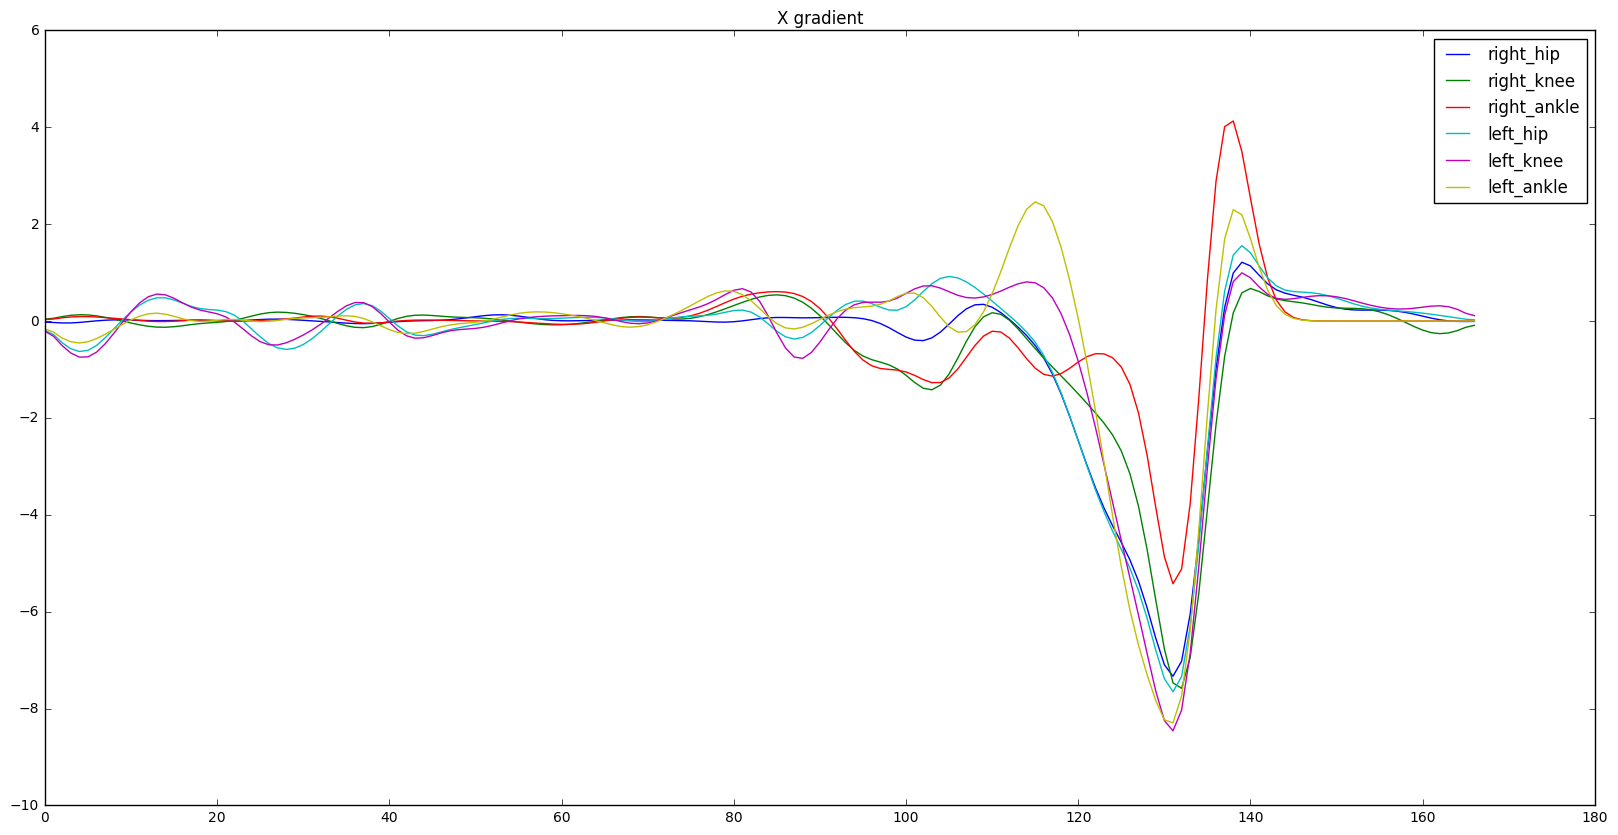

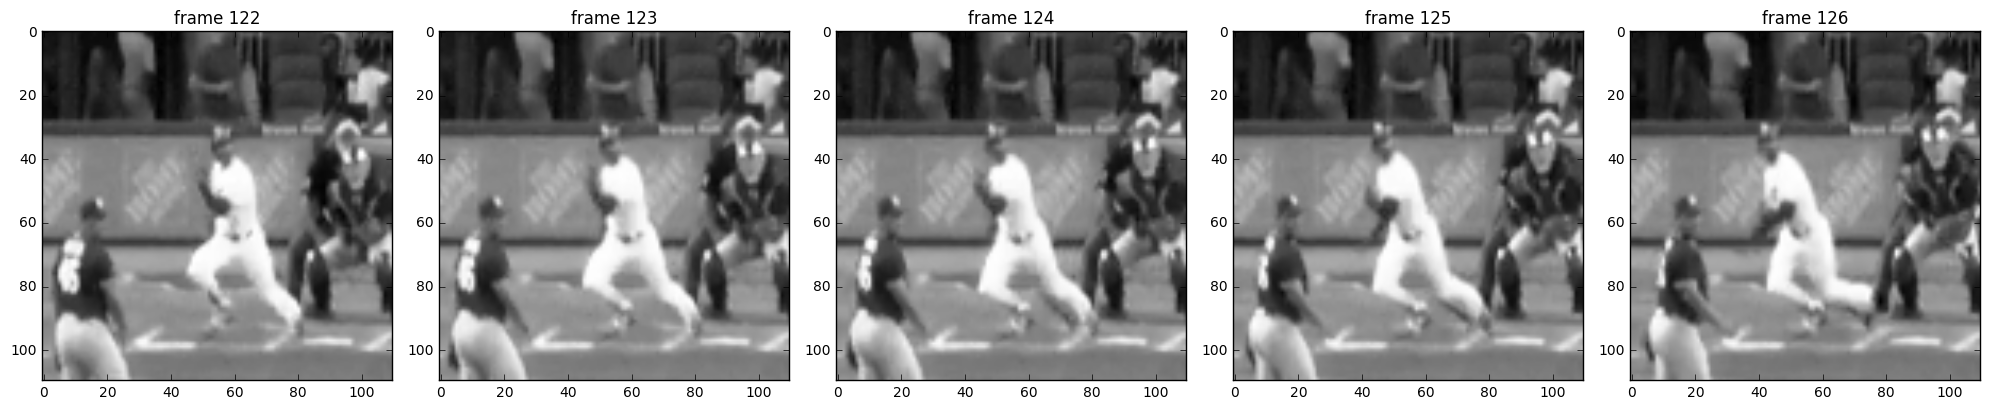


 
 
 

--------------NEW VIDEO ------------------
46188b82-c795-42e4-8eb1-db3d616d3b4f
-----------------Hit into play?  yes -----------
first_by_grad [ 14  15  16  17  18  19  20  21 134 135 136]
--------------START RUN:  14 ------------------


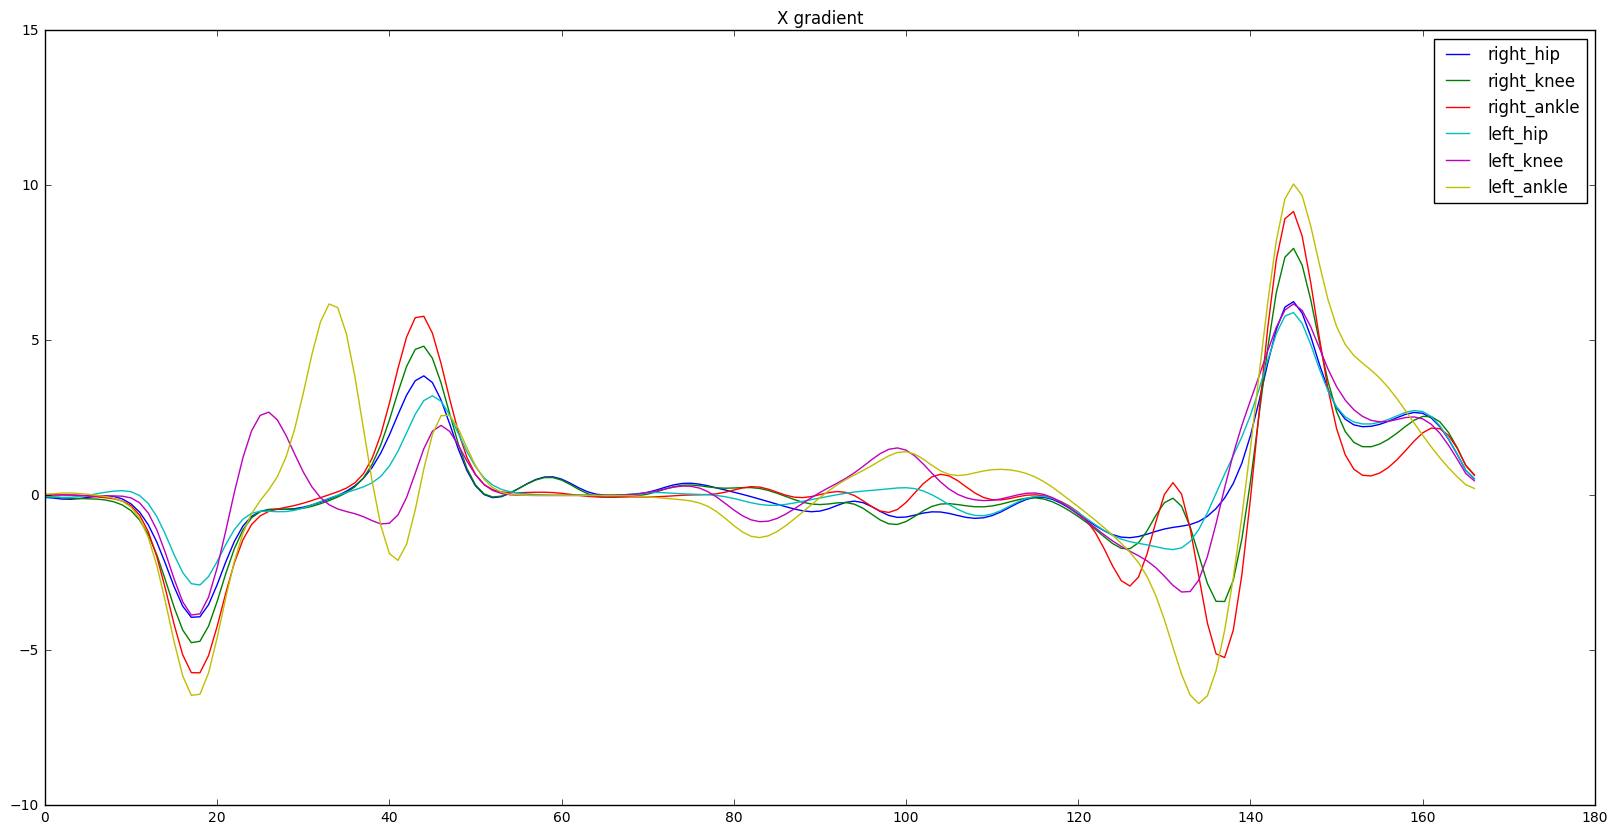

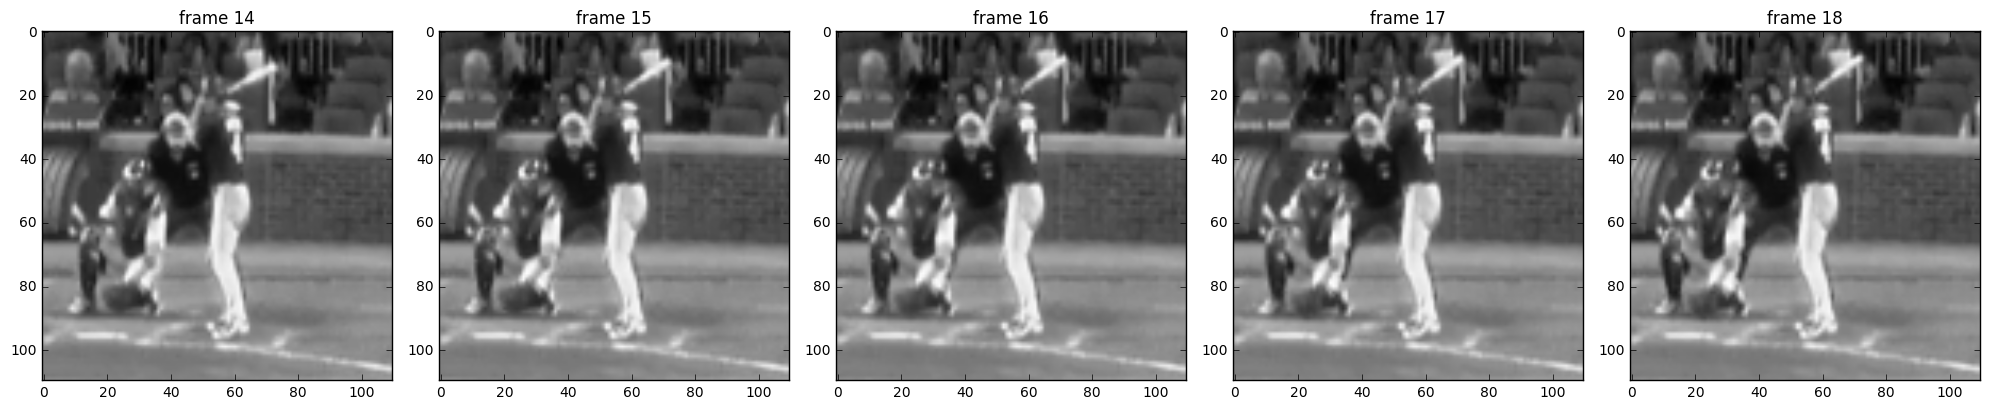


 
 
 

--------------NEW VIDEO ------------------
503890cc-eea7-49b0-8cfc-51dc0026d7e6
-----------------Hit into play?  yes -----------
first_by_grad [120 121 126 127 128 129 130 131 132 133 134 135 136 137 138 139]
--------------START RUN:  120 ------------------


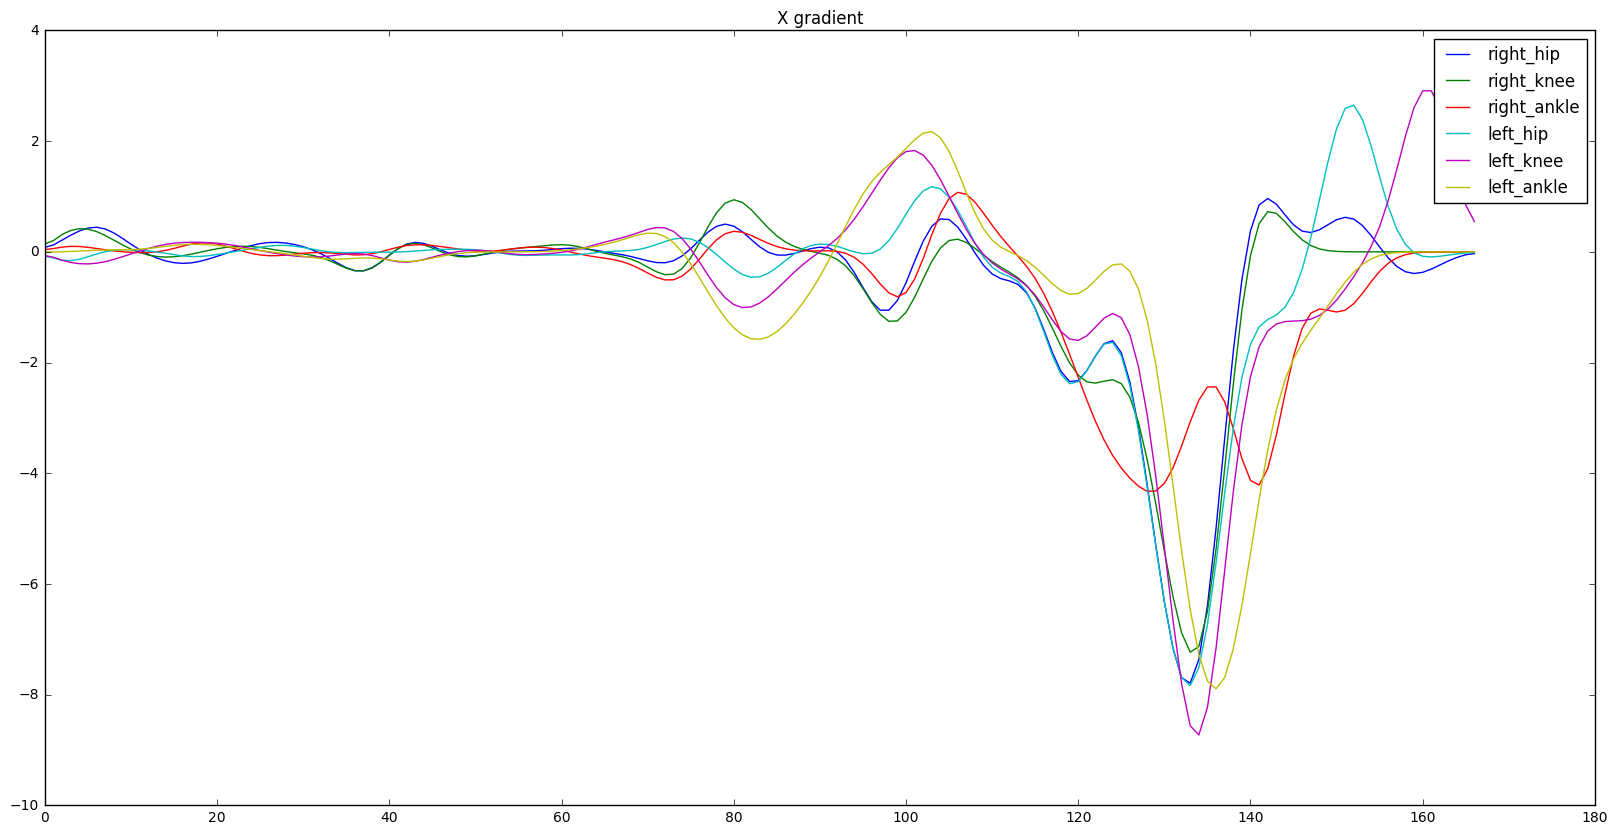

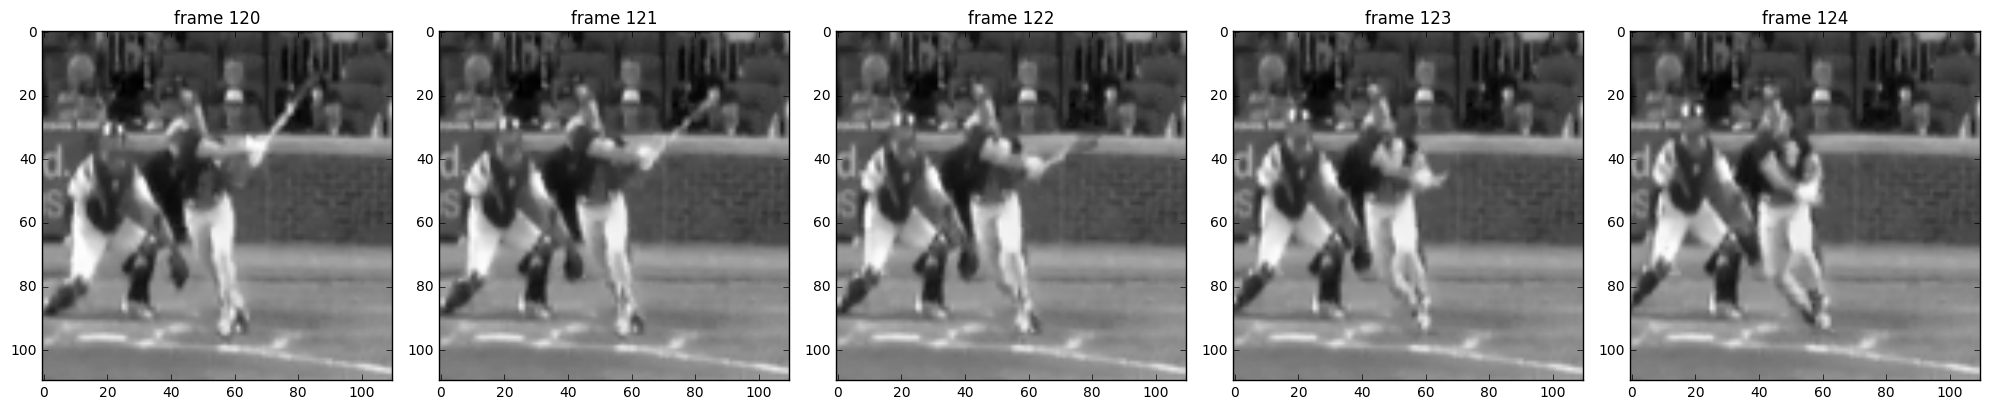


 
 
 

--------------NEW VIDEO ------------------
6c6fc979-c8f7-40d4-8541-e7ec7173a5c2
-----------------Hit into play?  yes -----------
first_by_grad []
--------------START RUN:  None ------------------


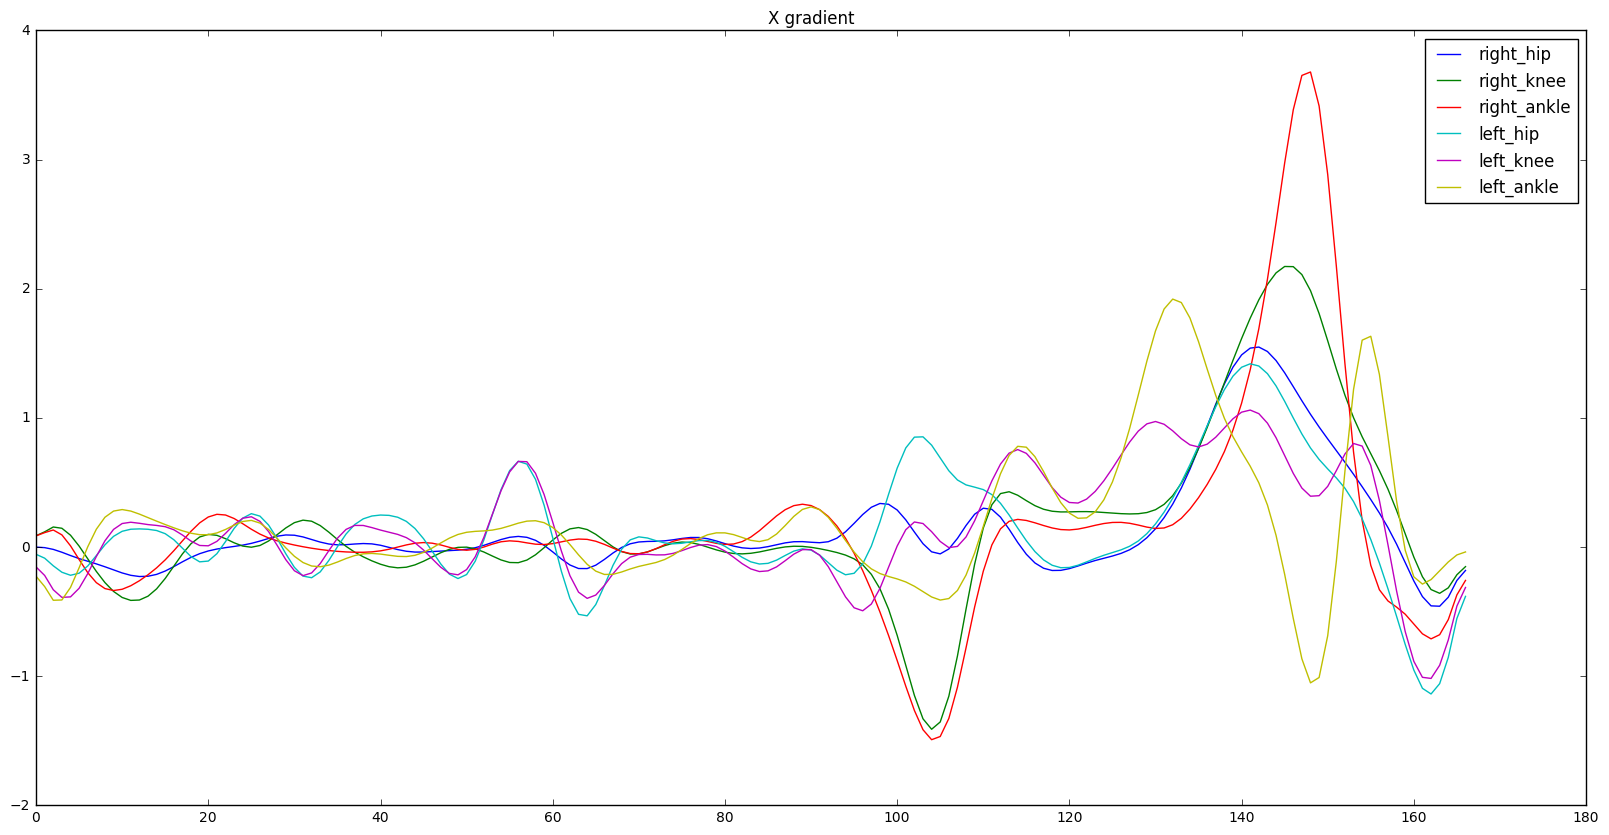


 
 
 

--------------NEW VIDEO ------------------
6ee95a4b-74da-4d39-9e82-1f060f4fd09b
-----------------Hit into play?  yes -----------
first_by_grad [123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140
 141 142 143 144]
--------------START RUN:  123 ------------------


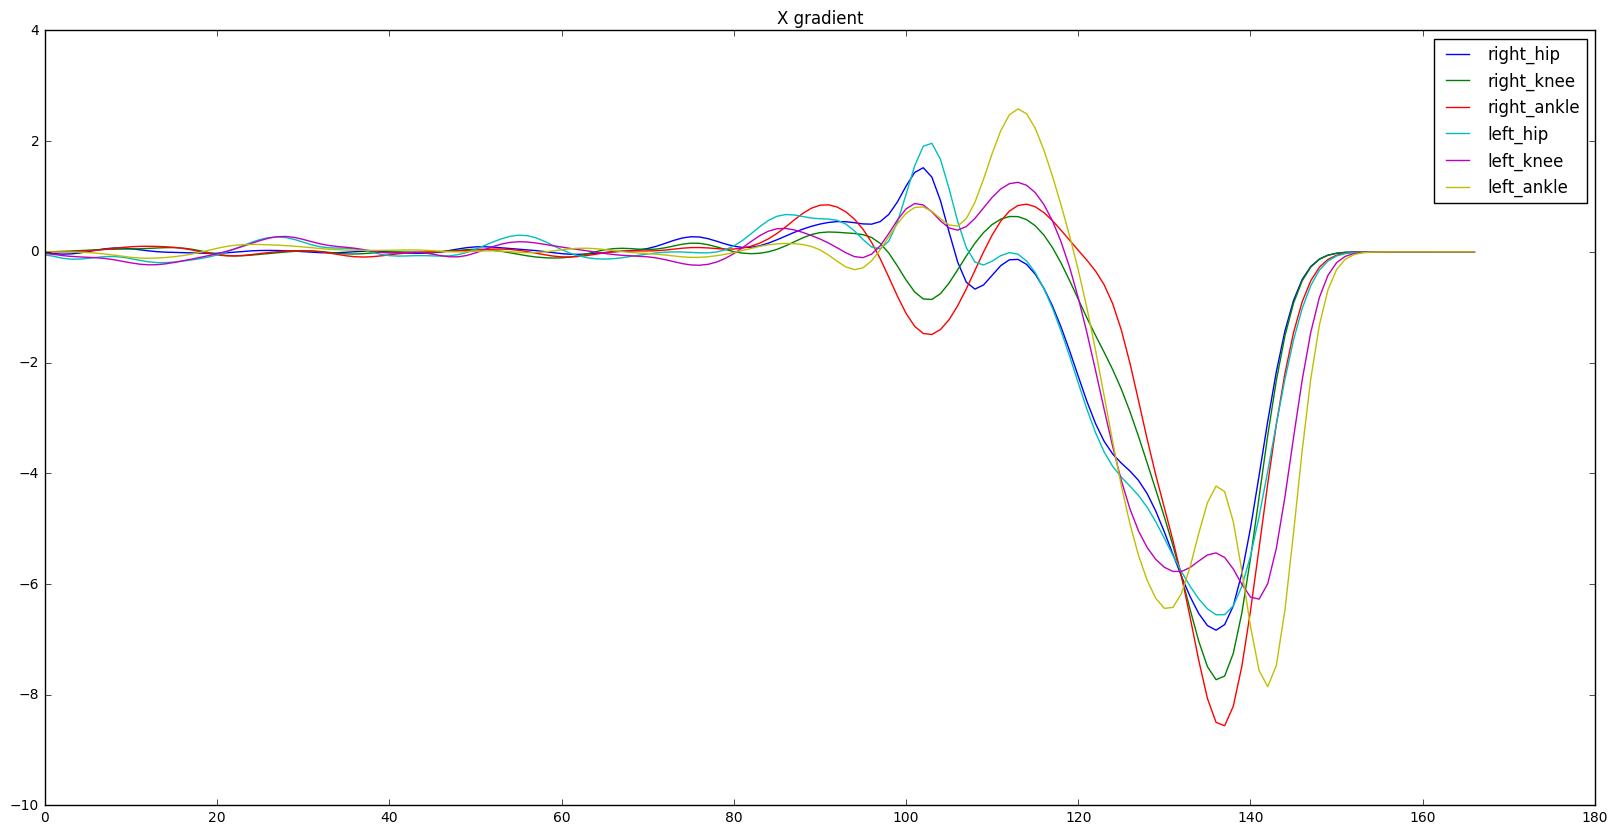

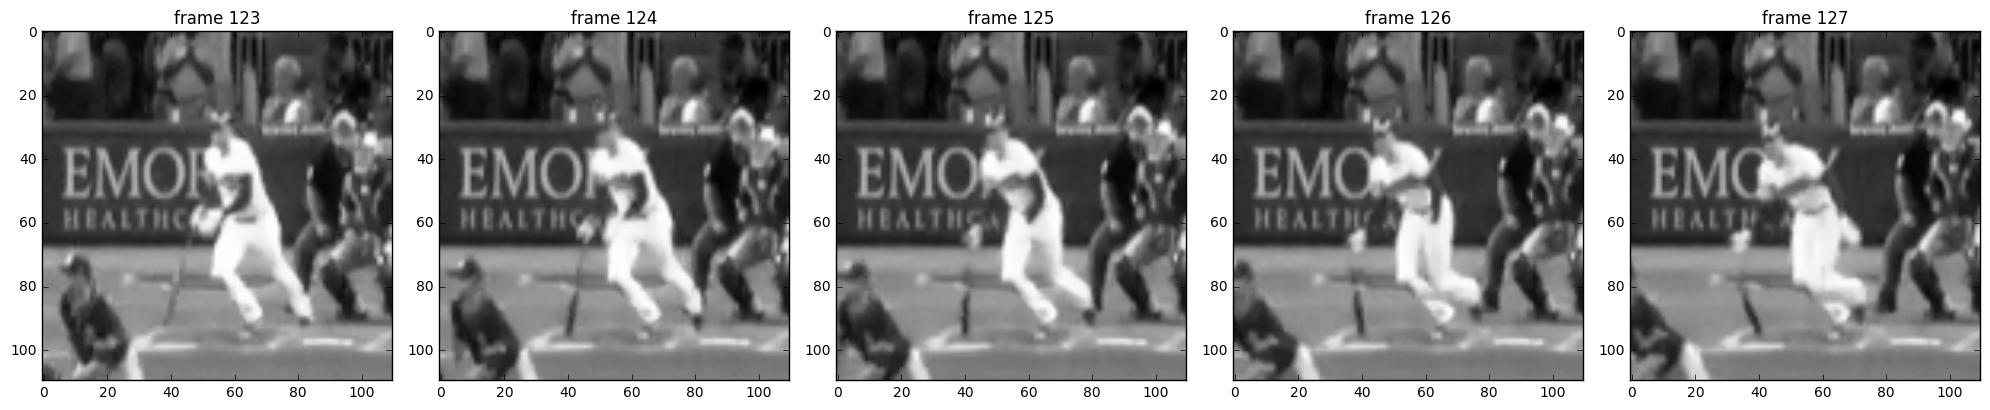


 
 
 

--------------NEW VIDEO ------------------
6f014362-1788-43d7-a3fe-91059be02304
-----------------Hit into play?  yes -----------
first_by_grad []
--------------START RUN:  None ------------------


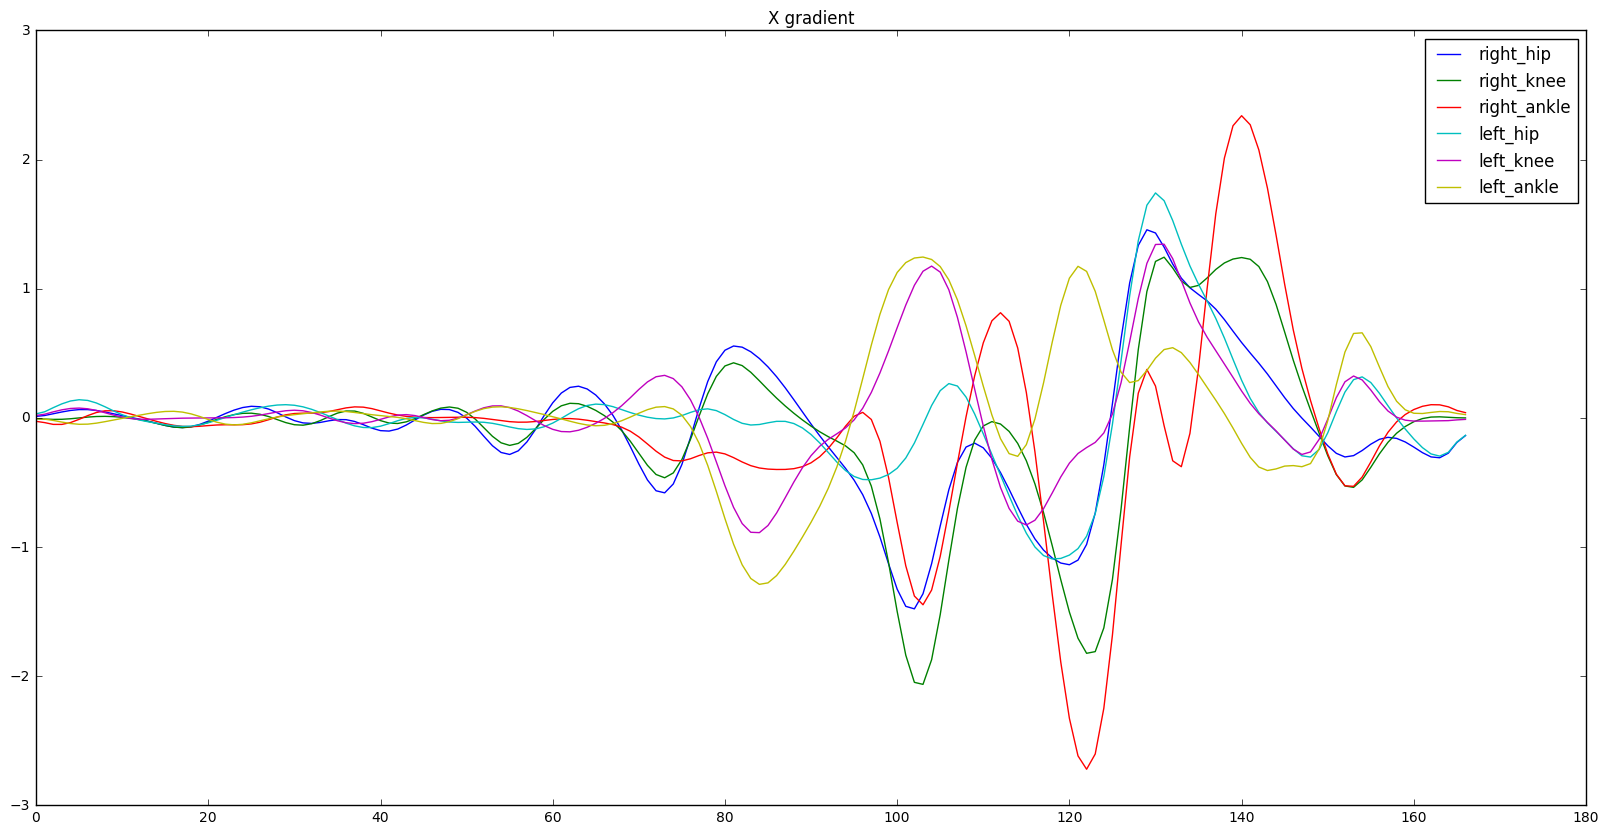


 
 
 

--------------NEW VIDEO ------------------
83764a69-2028-4530-8188-f7c37162d403
-----------------Hit into play?  yes -----------
first_by_grad [146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163]
--------------START RUN:  146 ------------------


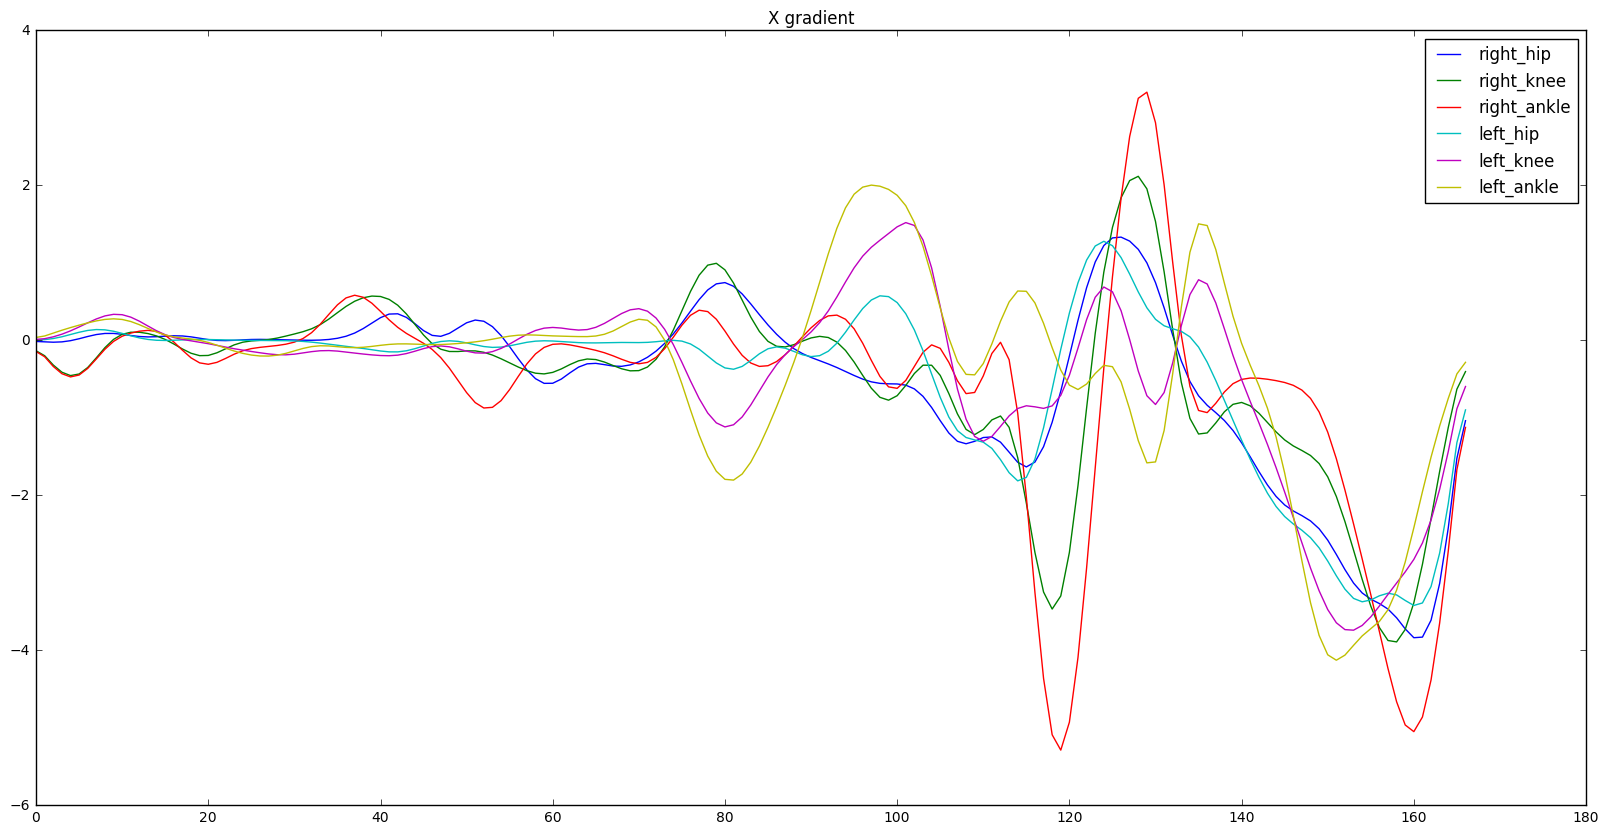

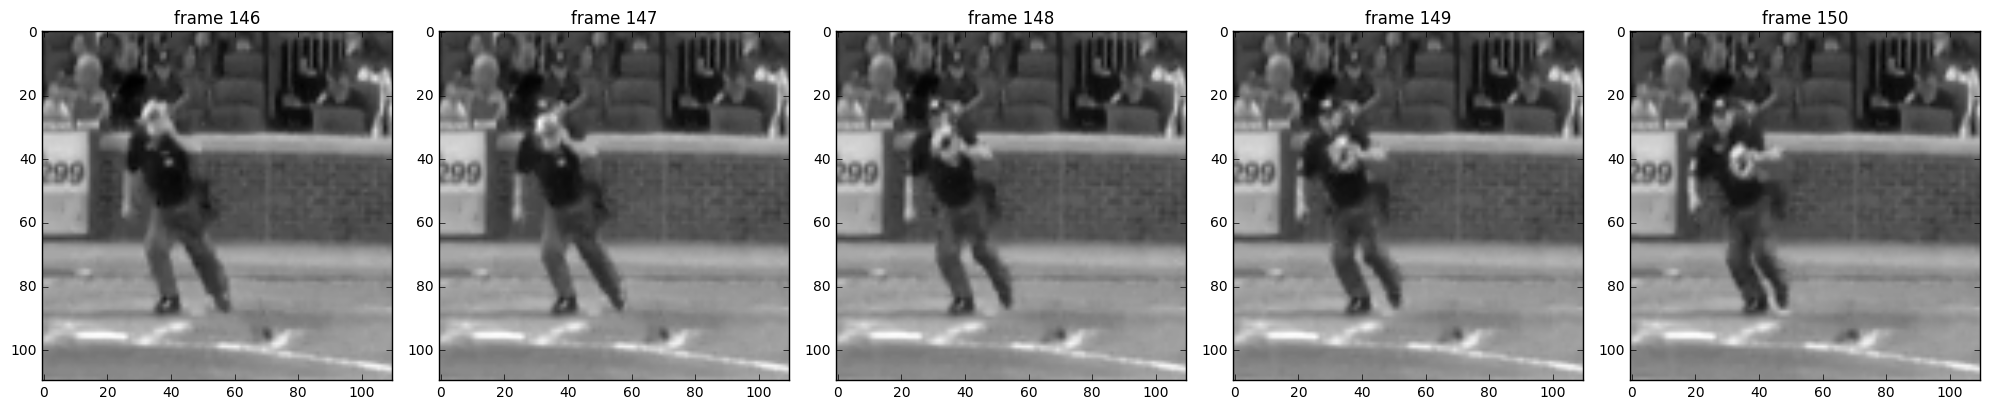


 
 
 

--------------NEW VIDEO ------------------
889613f9-85f0-4043-864b-f0d486a9816e
-----------------Hit into play?  yes -----------
first_by_grad [ 99 100 101 102 103 104 105]
--------------START RUN:  99 ------------------


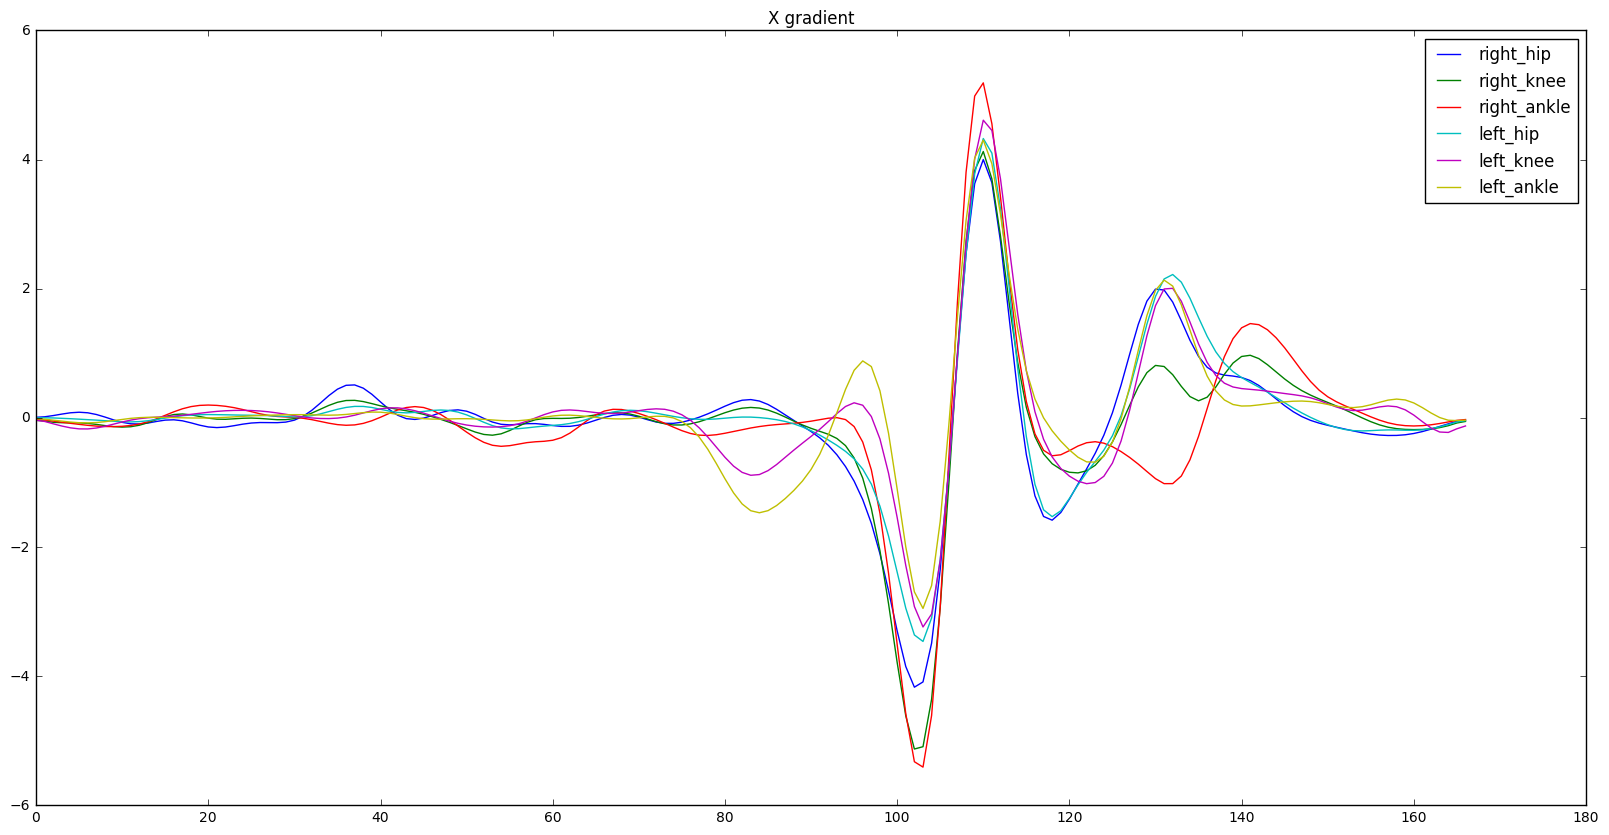

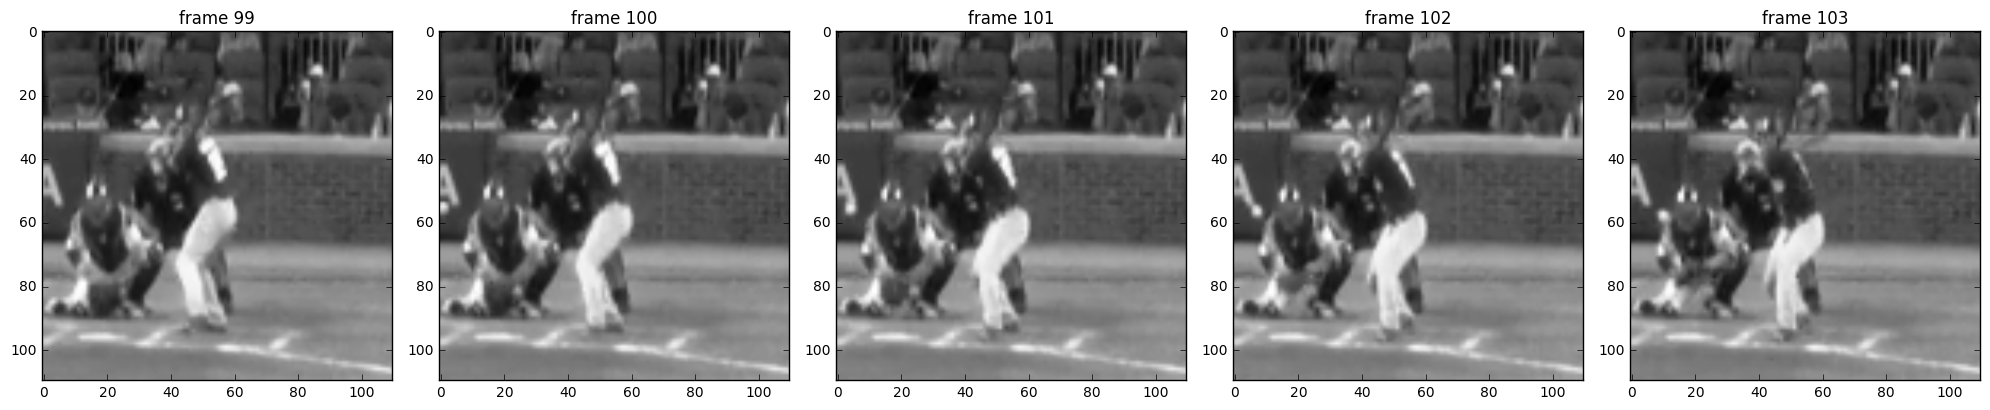


 
 
 

--------------NEW VIDEO ------------------
8de9a2b8-6ae4-4781-acc0-a51a64e21d39
-----------------Hit into play?  yes -----------
first_by_grad [123 124 125 126 127 128 129 130 131 132 133 134 135]
--------------START RUN:  123 ------------------


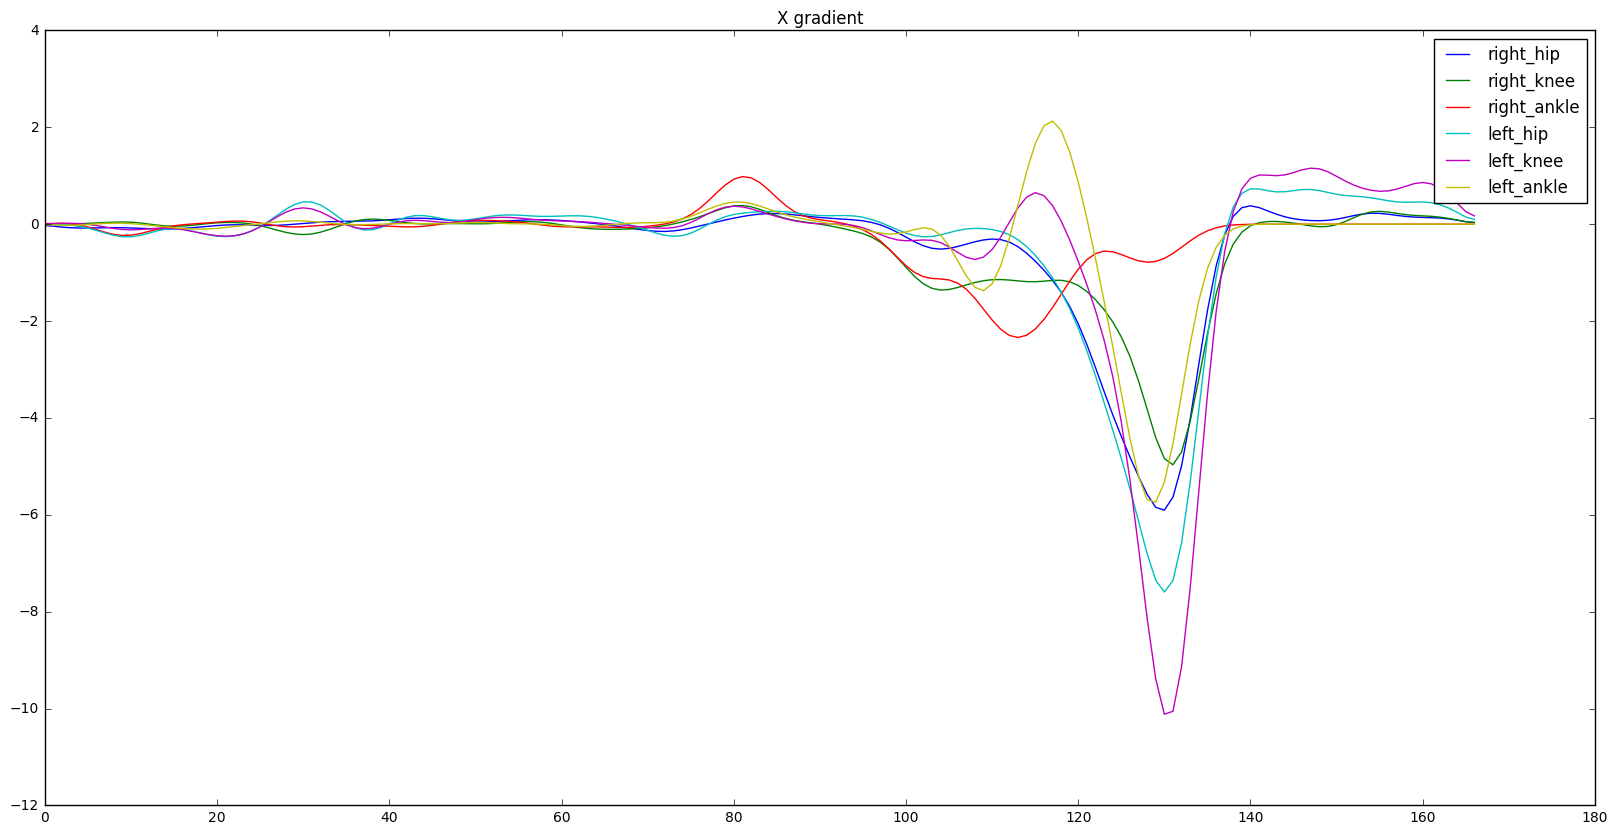

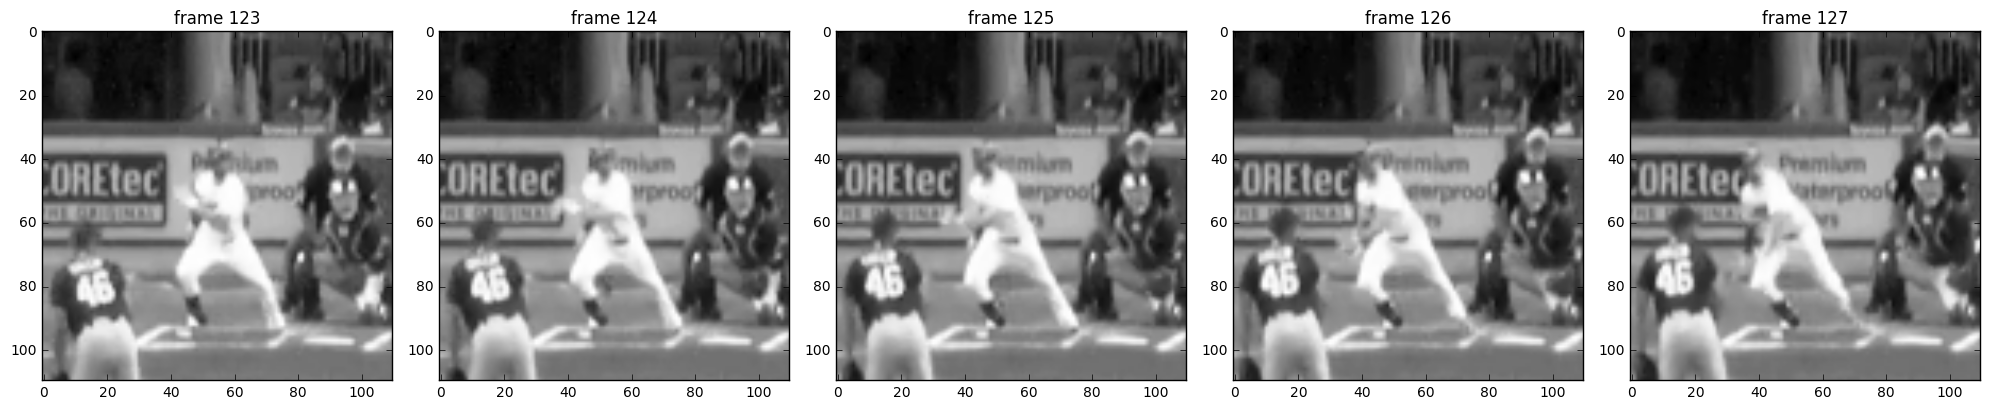


 
 
 

--------------NEW VIDEO ------------------
a85d53b8-2480-41f1-90ec-60fd8e22f5f9
-----------------Hit into play?  yes -----------
first_by_grad [125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142
 143 144 145 146 147 148]
--------------START RUN:  125 ------------------


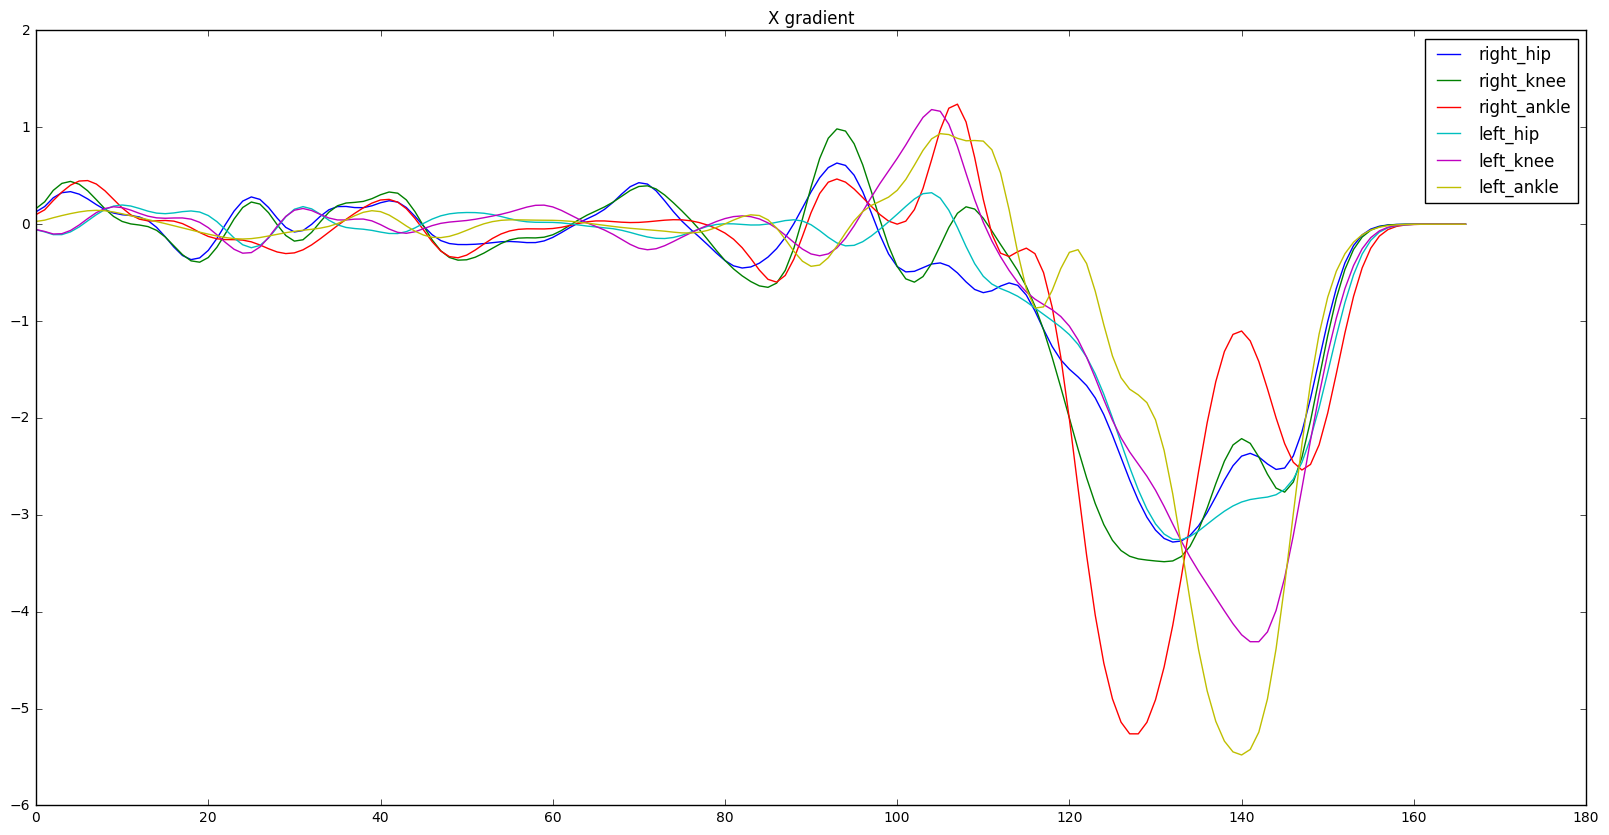

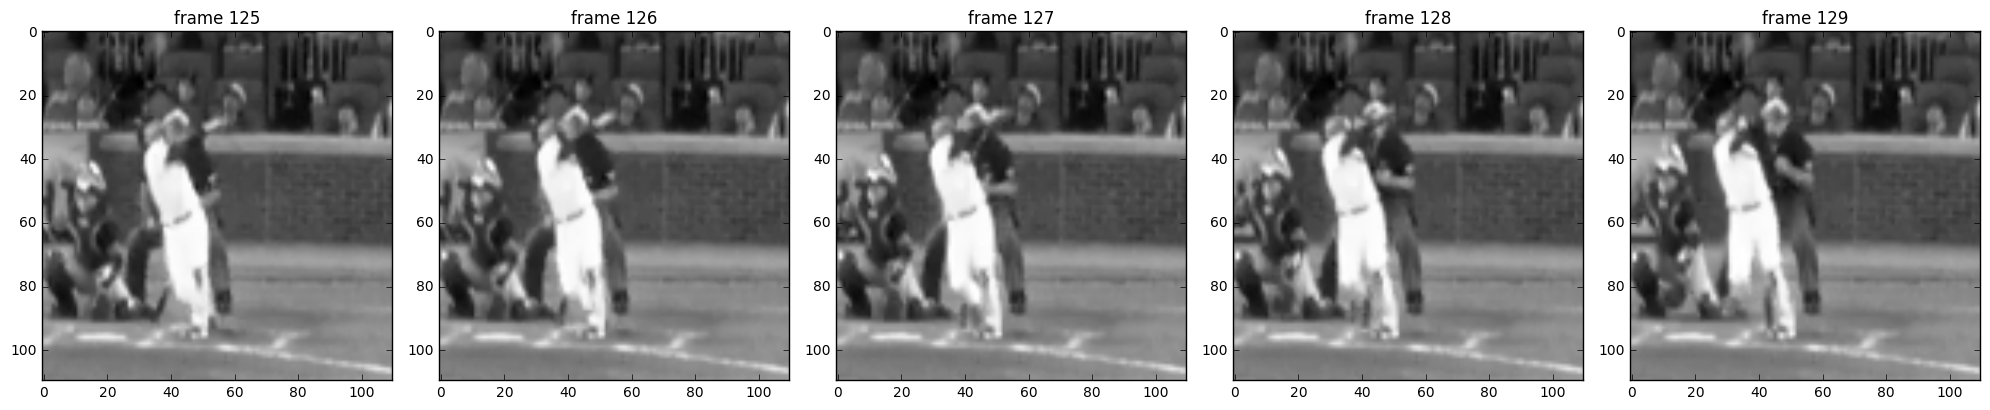


 
 
 

--------------NEW VIDEO ------------------
aa7193ad-30f0-4f3e-becb-4f68d0b65130
-----------------Hit into play?  yes -----------
first_by_grad [ 87  88  89  90  91  92  93  94  95  96 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156]
--------------START RUN:  87 ------------------


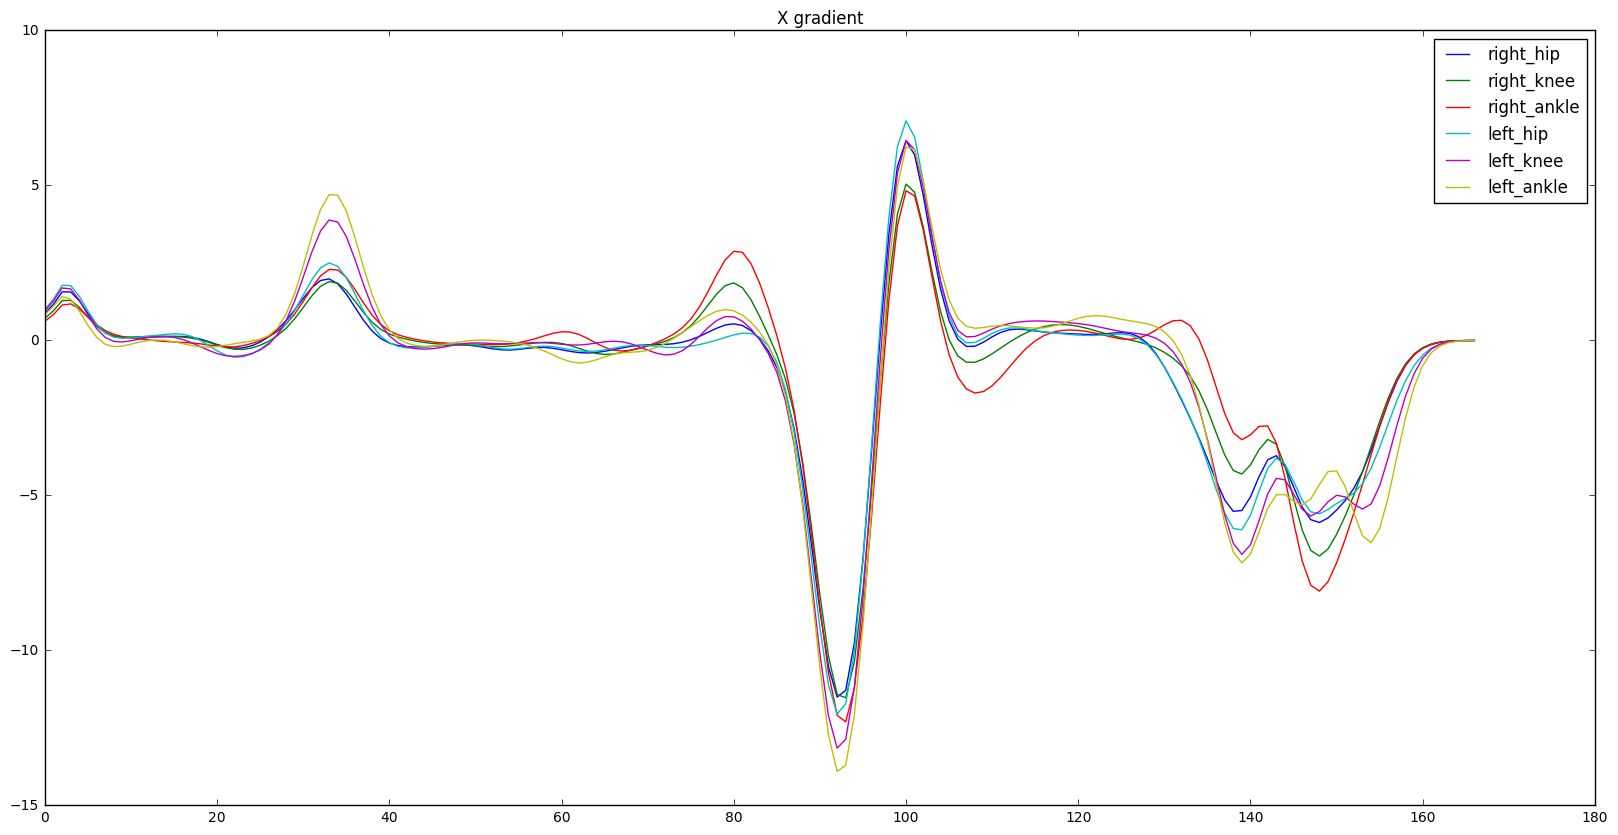

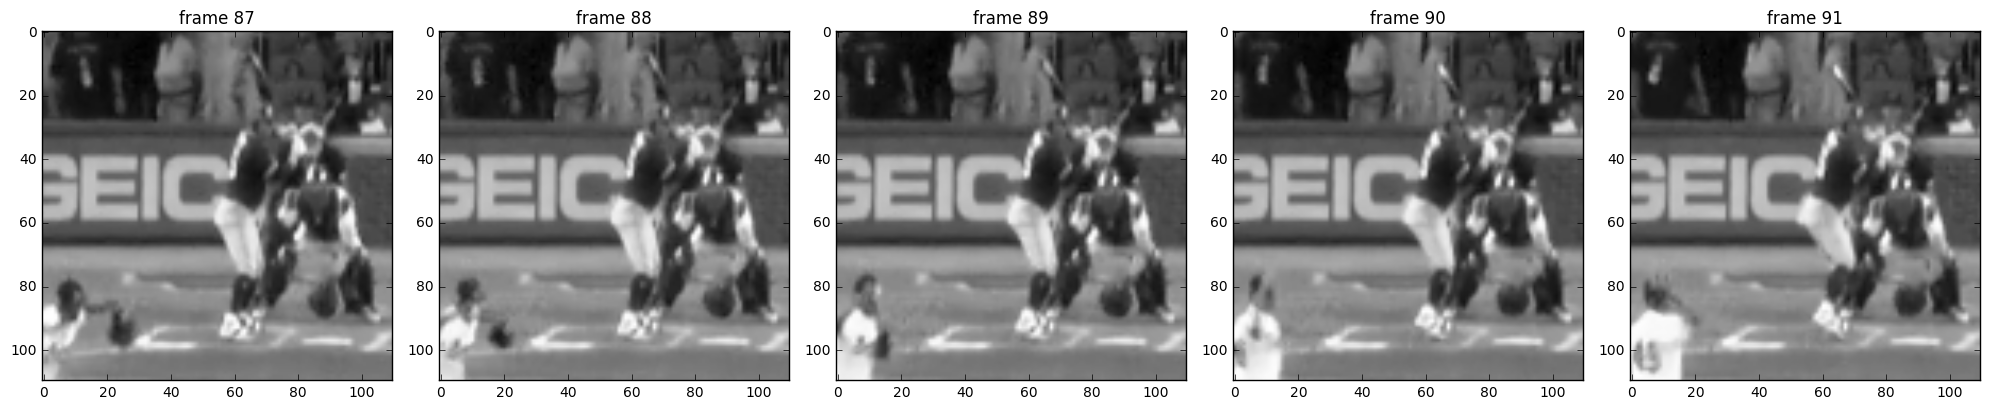


 
 
 

--------------NEW VIDEO ------------------
c3b0d39c-e764-4423-a999-9a08707b7c5b
-----------------Hit into play?  yes -----------
first_by_grad [123 124 125 126 127 128 129 130 131 132 133 134 135 136]
--------------START RUN:  123 ------------------


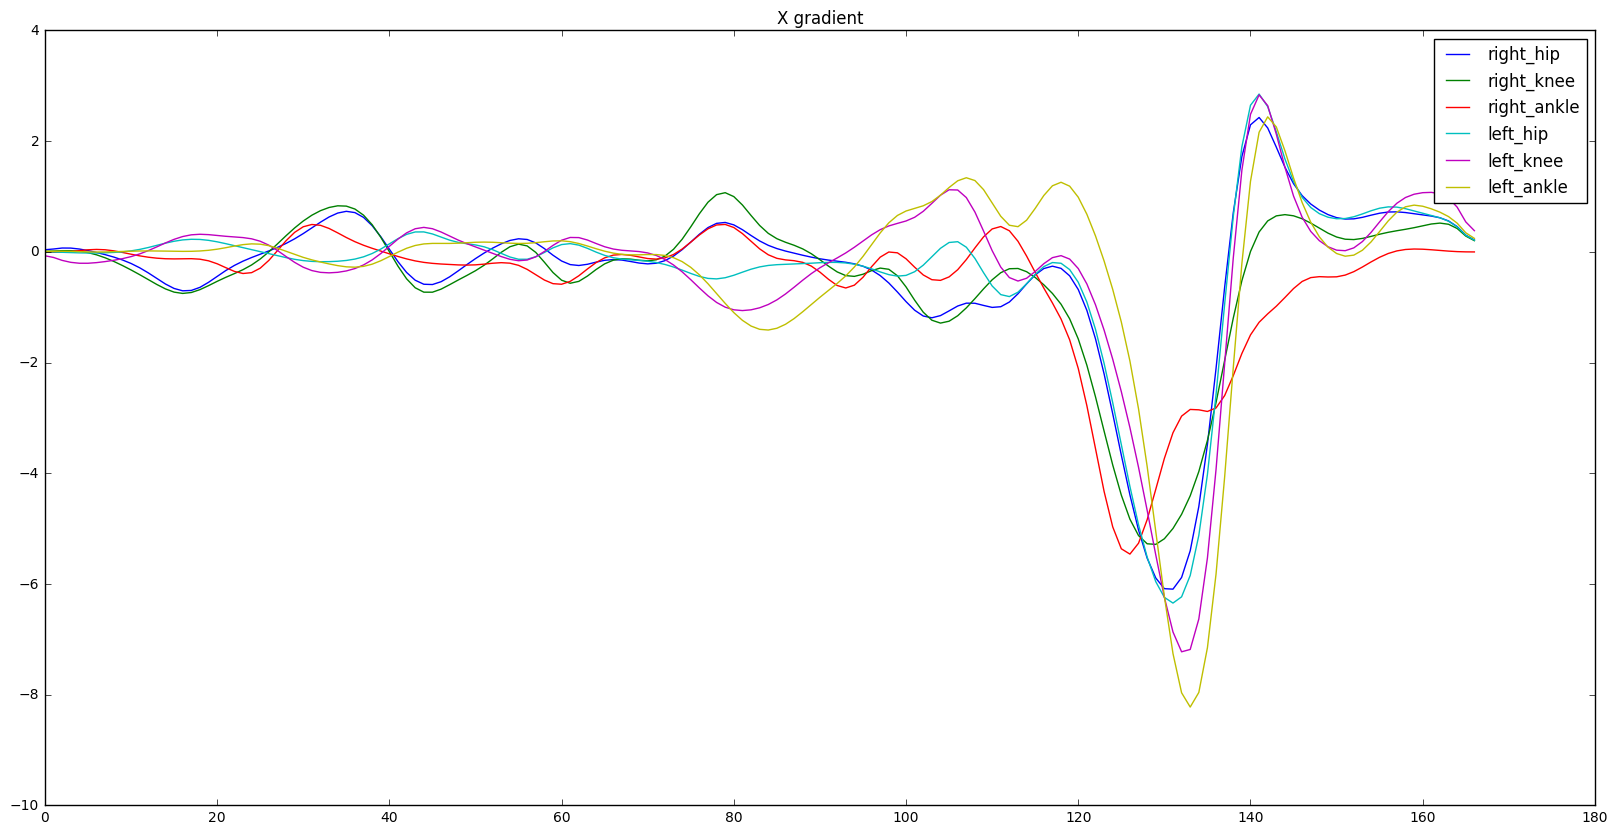

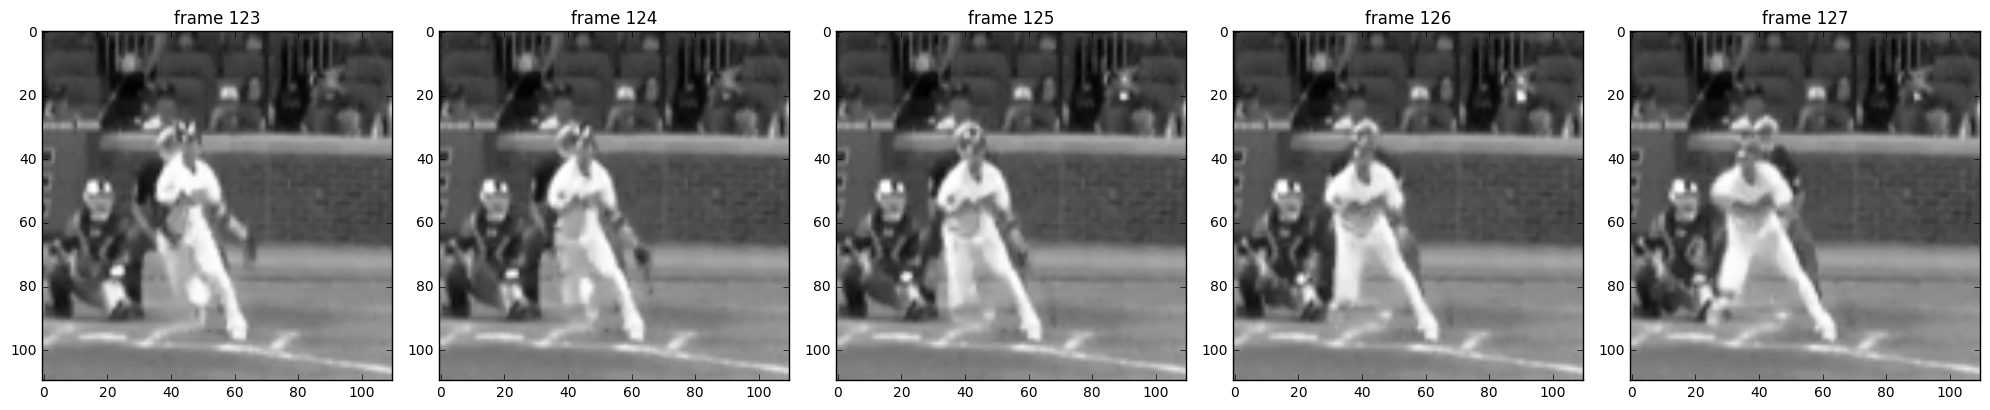


 
 
 

--------------NEW VIDEO ------------------
fa9ca64b-934f-4c35-ab6b-f8312c1c2f9a
-----------------Hit into play?  yes -----------
first_by_grad []
--------------START RUN:  None ------------------


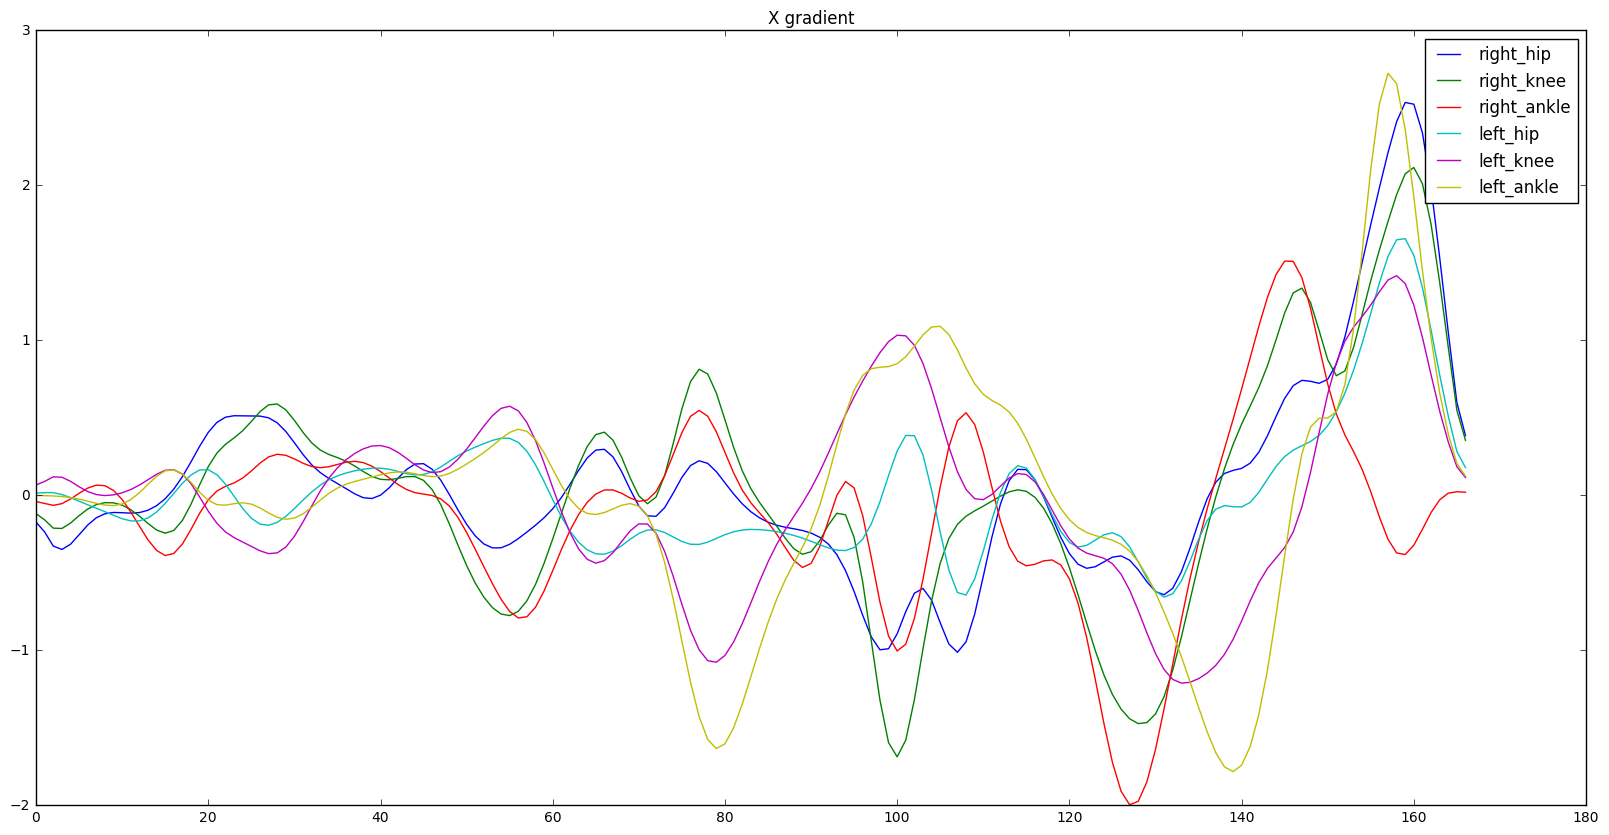

IndexError: list index out of range

In [31]:
for video_choice in range(53):
    if hit_into[video_choice]=="no":
        continue
    print("\n \n \n \n")
    print("--------------NEW VIDEO ------------------")
    print(files[video_choice])
    # first2 = first_by_grad(joints_array_batter[video_choice, :,:, 0], joints_list[:12], 1)
    # first_move = min(first1, first2)
    # first_move = center_gravity(joints_array[video_choice, :, :12], joint_weights=np.array([1,1, 0.3,0, 0.3, 0, 1, 2,0.5, 1, 2, 0.5]), cutoff = 0.4)
    # grad_pitcher(joints_array_batter[video_choice,:,joints_list.index(j), 0])[0]

    """
    hit_start = first_by_grad(joints_array_batter[video_choice, :,:, 0], joints_list[:6], 1)
    
    print("--------------START HIT: ", hit_start, "------------------")
    
    #hit_ball = local_maxima(joints_array_batter[video_choice, :,:, 1], joints_list[6:12], 6)
    #print("--------------HIT BALL: ", hit_ball, "------------------")
    
    plt.figure(figsize = (20,10))
    for j in joints_list[:6]:
        plt.plot(np.gradient(joints_array_batter[video_choice,:,joints_list.index(j), 0]), label = j)
    plt.legend()
    #plt.ylim(200, 100)
    plt.title("Y gradient")
    plt.show()
    
    if hit_start is not None:
        fig = plt.figure(figsize=(20, 5))
        show_frames = range(hit_start, hit_start+5) #[17, 18, 19, 20, 21]
        for ind, i in enumerate(show_frames):
            ax = fig.add_subplot(1,len(show_frames),ind+1)
            plt.imshow(videos_b[video_choice,i])
            plt.gray()
            plt.title("frame "+str(i))
        plt.tight_layout()
        plt.show()
    """ 
    
    print("-----------------Hit into play? ", hit_into[video_choice], "-----------")
    
    first_move = first_by_grad(joints_array_batter[video_choice, :,:, 1], joints_list[6:12], -2)
    
    print("--------------START RUN: ", first_move, "------------------")
    plt.figure(figsize = (20,10))
    for j in joints_list[6:12]:
        plt.plot(np.gradient(joints_array_batter[video_choice,:,joints_list.index(j), 1]), label = j)
    plt.legend()
    #plt.ylim(200, 100)
    plt.title("X gradient")
    plt.show()
    
    if first_move is not None:
        fig = plt.figure(figsize=(20, 5))
        show_frames = range(first_move, first_move+5) #[17, 18, 19, 20, 21]
        for ind, i in enumerate(show_frames):
            ax = fig.add_subplot(1,len(show_frames),ind+1)
            plt.imshow(videos_b[video_choice,i])
            plt.gray()
            plt.title("frame "+str(i))
        plt.tight_layout()
        plt.show()

In [16]:
print(csv.columns.tolist())

['Unnamed: 0', 'game_primary_key', 'play_id', 'venue_id', 'Regular Speed (P)', 'Zone Position X (Trackman)', 'Zone Position Z (Trackman)', 'Strike Zone Bottom', 'Umpire Call', 'Play Outcome', 'Pitcher', 'Catcher', '1st baseman', '2nd baseman', '3rd baseman', 'Shortstop', 'Left fielder', 'Center fielder', 'Right fielder', 'Batter', 'Timestamp', 'Hit into play?', 'Pitch Type', 'Batter side', 'Pitcher throws', 'inning', 'top_of_inning', 'at_bat', 'at_bat_pitch_number', 'release_position_at_50_feet_x', 'release_position_at_50_feet_y', 'release_position_at_50_feet_z', 'launch_direction', 'launch_angle', 'zone_speed', 'pre_pitch_outs', 'pre_pitch_balls', 'pre_pitch_strikes', 'pre_pitch_pitch_type', 'date', 'spin_dir', 'speed_at_50_feet']


In [20]:
for col in csv.columns.tolist():
    print(col)
    nonzero = np.logical_not(pd.isnull(csv[col].values))
    print(np.unique(csv[col].values[nonzero]))

Unnamed: 0
[    0     1     2 ..., 12359 12360 12361]
game_primary_key
[490251 490266 490281 490292 490309 490324 490335 490705 490716 490747
 490762 490770 490780 490795 490808 491107 491122 491137 491153 491167
 491182 491195 491205 491220 491235 491450 491465 491480 491494 491509
 491915 491930 491945 491964 491977 491992 492010 492025 492040 492303
 492318 492333 492413 492428]
play_id
['000135df-5d5f-4b73-8bad-c7f32f207969'
 '000622d0-31d7-4b0c-befd-b7413d64ebe4'
 '000ed30a-60fc-40ef-9db5-510d0171efcd' ...,
 'fff05f3c-673f-436a-8416-bd29e115cd57'
 'fff36cc5-0fe7-4aa1-ab98-a86332818f0b'
 'fffef631-8d09-4d1c-b92e-4ed3369c6130']
venue_id
[4705]
Regular Speed (P)
[ 52.476  61.48   65.095 ...,  99.117  99.258  99.461]
Zone Position X (Trackman)
[-3.68235 -3.35752 -3.2939  ...,  3.01112  3.01613  3.28417]
Zone Position Z (Trackman)
[-2.03974 -1.87173 -1.59887 ...,  5.4806   5.481    5.65229]
Strike Zone Bottom
[ 1.       1.11581  1.13523 ...,  2.04564  2.04684  2.05684]
Umpire Call
['Un

In [43]:
sv = pd.read_csv("/Users/ninawiedemann/Desktop/UNI/Praktikum/ALL/cf_data.csv")

/Users/ninawiedemann/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (253,254,255,256,257,258,259,289) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [48]:
releases = sv["first_movement_frame_index"].values
games = sv["Game"].values.tolist()
nonzero = np.logical_not(pd.isnull(releases))
not_null = releases[nonzero]
over_min = not_null[np.where(not_null>10)]
below_max = over_min[np.where(over_min<130)]
mean = np.mean(below_max)
print("mean", mean)
releases[np.where(np.isnan(releases))] = mean
releases[np.where(releases<=10)] = mean
releases[np.where(releases>=130)] = mean
    
with open("/Users/ninawiedemann/Desktop/UNI/Praktikum/ALL/notebooks/first_move_frames.json", "r") as infile:
    dic_lab = json.load(infile)
all_files = list(dic_lab.keys())

for i in range(50):
    ind = games.index(all_files[i])
    print("mylabel", dic_lab[all_files[i]], "official", releases[ind], all_files[i])

mean 49.7019776177
mylabel 63 official 33.0 490972-87c8ec63-2d88-4438-b627-c26b634b3891
mylabel 63 official 15.0 491001-1c2712b4-8cfe-4d09-89be-539bc0b1d368
mylabel 62 official 48.0 491001-d57c1e13-d30c-49e3-bdeb-8fb5c7dd78c9
mylabel 82.0 official 58.0 491001-f3604c1a-0060-4fe4-b928-b309ed256ba6
mylabel 86.0 official 70.0 490987-07cc8175-e423-46b3-9a77-aa272dff9cf6
mylabel 83.0 official 45.0 490959-ac231ad4-2c7a-4982-80ad-166bf78f31cd
mylabel 60.0 official 28.0 490972-1a5cd899-91b8-4cc5-841c-8cf38b1f1d15
mylabel 62.0 official 21.0 490972-5d6cfbd2-de5e-4710-81af-7e0037e16944
mylabel 76.0 official 67.0 490959-b996ebf3-4b48-4814-8368-f104110d524d
mylabel 76.0 official 72.0 490987-f28861ea-2e04-4764-b851-ce9fd4caf400
mylabel 86.0 official 70.0 490987-e9945e91-66ad-48c7-9db0-4ff65b23b6d6
mylabel 89.0 official 38.0 491001-46a57a77-dd30-4500-bf8a-dd3fb893ee25
mylabel 63.0 official 67.0 490987-9f377a73-7711-4882-b212-247b11d21f3b
mylabel 90.0 official 68.0 491001-69cad339-0478-45c5-96ed-97c6e8